In [6]:
# pip install cvxpy openpyxl ecos scs

In [7]:
import numpy as np, pandas as pd, cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
import warnings
warnings.filterwarnings("ignore")
import json
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Liabilities

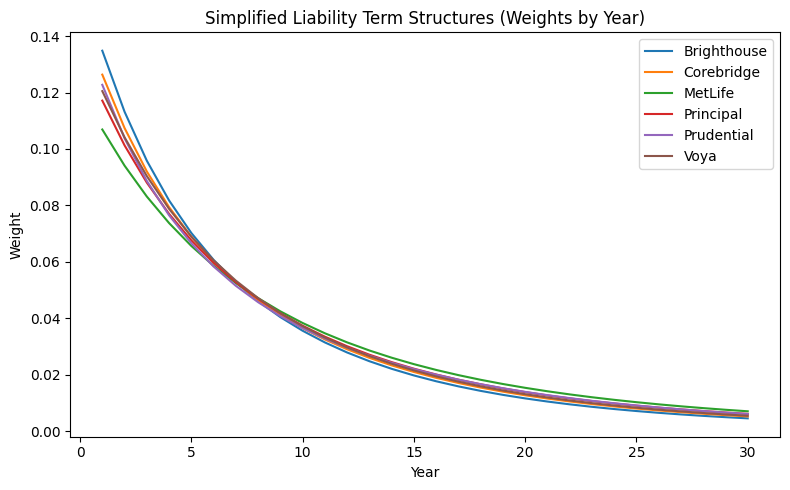

'Liability_Profiles.xlsx'

In [8]:
T = 30
years = np.arange(1, T + 1)

# --- Bucket duration presets (years) ---
# Keep these simple and consistent; you can tweak per company if desired.
bucket_durations_default = {
    "Short": 4.0,
    "Medium": 8.0,
    "Long": 20.0,
}

# --- Company-specific mixes (weights must sum to 1) ---
# These are intentionally simple and aligned with each company's product mix:
# - More "retirement / VA hedging" -> more Medium, some Short
# - More "ULSG / payout annuities"  -> more Long
# - More "group benefits / stable value" -> more Short
company_bucket_weights = {
    "Brighthouse": {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
    "Corebridge":  {"Short": 0.25, "Medium": 0.55, "Long": 0.20},
    "MetLife":     {"Short": 0.20, "Medium": 0.50, "Long": 0.25},
    "Principal":   {"Short": 0.15, "Medium": 0.60, "Long": 0.20},
    "Prudential":  {"Short": 0.35, "Medium": 0.45, "Long": 0.20},
    "Voya":        {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
}

# Optionally tweak bucket durations per company (keep it very minor/simple)
company_bucket_durations = {
    "Brighthouse": {"Short": 3.0, "Medium": 7.0, "Long": 15.0},
    "Corebridge":  {"Short": 3.0, "Medium": 7.0, "Long": 15.0},
    "MetLife":     {"Short": 4.0, "Medium": 8.0, "Long": 17.0},
    "Principal":   {"Short": 3.0, "Medium": 7.0, "Long": 17.0},
    "Prudential":  {"Short": 3.0, "Medium": 8.0, "Long": 16.0},
    "Voya":        {"Short": 4.0, "Medium": 8.0, "Long": 17.0},
}

def make_liability_curve(weights, durations, years):
    """
    Exponential-decay blend:
        CF_t ∝ sum_b [ w_b * exp(-t / D_b) ]
    Then normalize so weights sum to 1 across t=1..T.
    """
    curve = np.zeros_like(years, dtype=float)
    for b, w in weights.items():
        D = durations[b]
        curve += w * np.exp(-years / D)
    curve /= curve.sum()
    return curve

# Build curves and summary metrics
records = []
summary_rows = []
curves = {}

for company, wts in company_bucket_weights.items():
    durs = company_bucket_durations.get(company, bucket_durations_default)
    curve = make_liability_curve(wts, durs, years)
    curves[company] = curve

    # Simple "Macaulay-like" stats on the discrete weights (no discount curve applied here)
    duration_years = float(np.sum(curve * years))
    convexity = float(np.sum(curve * (years ** 2)))  # rough proxy (unscaled)

    # Liquidity metrics (share of total CF in first 1y / 5y)
    liq_1y = float(curve[0])  # year 1 weight
    liq_5y = float(np.sum(curve[:5]))

    # Save per-year records
    for t, wt in zip(years, curve):
        records.append({"Company": company, "Year": t, "Liability_Weight": wt})

    summary_rows.append({
        "Company": company,
        "Avg_Duration_yrs": duration_years,
        "Convexity_proxy": convexity,
        "Share_1Y": liq_1y,
        "Share_5Y": liq_5y,
        "Short_wt": wts["Short"],
        "Medium_wt": wts["Medium"],
        "Long_wt": wts["Long"],
        "Short_D": durs["Short"],
        "Medium_D": durs["Medium"],
        "Long_D": durs["Long"],
    })

df_curves = pd.DataFrame(records)
df_summary = pd.DataFrame(summary_rows).set_index("Company")

# Plot all six curves on one chart (each line is the per-year weight)
plt.figure(figsize=(8, 5))
for company, curve in curves.items():
    plt.plot(years, curve, label=company)
plt.title("Simplified Liability Term Structures (Weights by Year)")
plt.xlabel("Year")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# Build an Excel workbook with:
# - Assumptions sheet (bucket weights & durations)
# - LiabilityCurves sheet (per company, per year weights)
# - Summary sheet (duration, convexity proxy, liquidity shares)
assumptions_rows = []
for company in company_bucket_weights:
    row = {"Company": company}
    row.update({f"BucketWeight_{k}": v for k, v in company_bucket_weights[company].items()})
    row.update({f"BucketDur_{k}": v for k, v in company_bucket_durations[company].items()})
    assumptions_rows.append(row)
df_assumptions = pd.DataFrame(assumptions_rows).set_index("Company")

excel_path = "Liability_Profiles.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_assumptions.to_excel(writer, sheet_name="Assumptions")
    df_curves.pivot(index="Year", columns="Company", values="Liability_Weight").to_excel(writer, sheet_name="LiabilityCurves")
    df_summary.to_excel(writer, sheet_name="Summary")

excel_path

##### Parameters

In [9]:
EXCEL_PATH = "final_inputs.xlsx"
SHEET_NAME = 0
RISK_FREE = 0.04
N_FRONTIER_POINTS = 200
# DUR_TARGET = 6.0
# DUR_TOL = 1.0
LIQUID_MIN = None
W_MIN_DEFAULT = 0.00
W_MAX_DEFAULT = 0.10
LIABILITY_BOOK_PATH = "Liability_Profiles.xlsx"
LIABILITY_COMPANY = None
KRD_TOL = 0.30
SURPLUS_LAMBDA  = 8.0     # risk aversion on variance term (sweep to trace a frontier)
CAP_PENALTY_PHI  = 0.2    # φ in -φ*(cap_charge' w). Set >0 to penalize RBC use in objective
USE_KRD_MATCH    = False    # turn KRD (bucket match) on/off
KEY_BUCKETS = {"KR5": (0,7), "KR10": (7,12), "KR20": (12,40)}
# === Simulation knobs (forecast error + covariance robustness) ===
MU_NOISE_SCALE_MKT = 0.04   # common "market" shock share of typical asset vol (forecast error, not raw vol)
MU_NOISE_SCALE_ID  = 0.05   # idiosyncratic share
SIGMA_RHO_JITTER   = 0.01   # correlation jitter magnitude (0..~0.1 is mild)
SIGMA_VOL_JITTER   = 0.02   # per-asset vol jitter
SIGMA_SHRINK_ALPHA = 0.4   # shrink Sigma_sim back to base Sigma for conditioning

##### Helpers

In [10]:
def nearest_psd(A, eps=1e-10):
    B = 0.5 * (A + A.T)
    vals, vecs = np.linalg.eigh(B)
    vals_clipped = np.maximum(vals, eps)
    return vecs @ np.diag(vals_clipped) @ vecs.T

def rating_to_numeric_fixed(rating):
    """Returns rating score only for fixed income assets, None for others"""
    scale = {
        "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
        "A+": 5, "A": 6, "A-": 7,
        "BBB+": 8, "BBB": 9, "BBB-": 10,
        "BB+": 11, "BB": 12, "BB-": 13,
        "B+": 14, "B": 15, "B-": 16,
        "CCC": 17, "CC": 18, "C": 19
    }
    rating_str = str(rating).strip()
    if rating_str in scale:
        return scale[rating_str]
    else:
        return None  # No rating = not fixed income

def load_inputs(path, sheet=0):
    df = pd.read_excel(path, sheet_name=sheet).dropna(how="all")
    assets = df.iloc[:, 0].astype(str).values
    ratings = df.iloc[:, 1].astype(str).values
    mu = df.iloc[:, 2].astype(float).values
    cap_charge = df.iloc[:, 3].astype(float).values
    sigma_ref = df.iloc[:, 4].astype(float).values
    duration = df.iloc[:, 5].astype(float).fillna(0.0).values
    brighthouse_alloc = df.iloc[:, 6].astype(float).values
    corebridge_alloc = df.iloc[:, 7].astype(float).values
    metlife_alloc = df.iloc[:, 8].astype(float).values
    principal_alloc = df.iloc[:, 9].astype(float).values
    prudential_alloc = df.iloc[:, 10].astype(float).values
    voya_alloc = df.iloc[:, 11].astype(float).values
    n = len(assets)
    cov = df.iloc[:, 12:12+n].astype(float).values
    if cov.shape != (n, n):
        raise ValueError(f"Covariance must be {n}x{n}, got {cov.shape}")
    S = nearest_psd(0.5 * (cov + cov.T))
    
    # Package company allocations into a dictionary
    company_allocations = {
        'Brighthouse': brighthouse_alloc,
        'Corebridge': corebridge_alloc,
        'MetLife': metlife_alloc,
        'Principal': principal_alloc,
        'Prudential': prudential_alloc,
        'Voya': voya_alloc
    }
    
    return assets, ratings, mu, cap_charge, sigma_ref, duration, S, company_allocations

def load_liability_profiles(path="Liability_Profiles.xlsx"):
    """Load liability duration profiles for all companies"""
    df_summary = pd.read_excel(path, sheet_name="Summary", index_col=0)
    return df_summary


def liability_bucket_targets(liability_path, company, key_buckets=KEY_BUCKETS):
    """Read Liability_Profiles.xlsx -> 'LiabilityCurves' sheet and compute target weights per key bucket."""
    df = pd.read_excel(liability_path, sheet_name="LiabilityCurves").set_index("Year")
    if company not in df.columns:
        raise ValueError(f"Company '{company}' not in 'LiabilityCurves' sheet.")
    curve = df[company].values
    T = len(curve)
    def clip(i): return max(1, min(T, i))
    targets = {}
    for name, (lo, hi) in key_buckets.items():
        a, b = clip(lo+1), clip(hi)      # make ranges inclusive of years
        targets[name] = float(np.sum(curve[a-1:b]))
    s = sum(targets.values())
    if s > 0:
        for k in targets: targets[k] /= s
    return targets

def asset_bucket_matrix_by_duration(asset_durations, key_buckets=KEY_BUCKETS):
    """Coarse KRD proxy: put each asset into the bucket that contains its effective duration."""
    n = len(asset_durations)
    names = list(key_buckets.keys())
    B = np.zeros((n, len(names)))
    for i, D in enumerate(asset_durations):
        placed = False
        for j, (name, (lo, hi)) in enumerate(key_buckets.items()):
            if lo < D <= hi:
                B[i, j] = 1.0
                placed = True
                break
        if not placed:
            if D <= list(key_buckets.values())[0][0] + 1e-9: B[i, 0] = 1.0
            else: B[i, -1] = 1.0
    return B, names

def solve_surplus_qp(mu, S, duration, cap_charge, wmin, wmax,
                     assets, ratings, rating_scores,
                     company_liability_duration,
                     krd_targets=None, B=None, krd_names=None, krd_tol=0.10,
                     surplus_lambda=SURPLUS_LAMBDA, cap_penalty_phi=CAP_PENALTY_PHI):
    """
    Maximize: mu'w - λ w'Sw - φ (cap_charge'w)
    Subject to: weights, duration band, credit-quality mix, asset class caps, optional KRD bucket match.
    """
    n = len(mu)
    w = cp.Variable(n)

    # Objective: surplus-like quadratic utility with capital penalty
    objective = cp.Maximize(mu @ w - surplus_lambda * cp.quad_form(w, S) - cap_penalty_phi * (cap_charge @ w))

    constraints = [
        cp.sum(w) == 1,
        w >= wmin,
        w <= wmax,
        duration @ w >= company_liability_duration - 1.0,
        duration @ w <= company_liability_duration + 1.0
    ]

    # Credit-quality: average score <= A+ (5)
    has_rating = np.array([s is not None for s in rating_scores])
    if has_rating.any():
        rated_w = w[has_rating]
        rated_scores = np.array([s for s in rating_scores if s is not None])
        tot = cp.sum(rated_w)
        constraints += [rated_scores @ rated_w <= 5 * tot]

    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])

    constraints += [
        cp.sum(w[is_bbb]) <= 0.15,
        cp.sum(w[is_below_ig]) <= 0.05
    ]

    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array(["Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alts = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alts

    constraints += [
        cp.sum(w[is_equity]) <= 0.05,
        cp.sum(w[is_hy_loans]) <= 0.05,
        cp.sum(w[is_emd_ig]) <= 0.10,
        cp.sum(w[is_real_estate]) <= 0.05,
        cp.sum(w[is_cml]) <= 0.20,
        cp.sum(w[is_direct_lending]) <= 0.20,
        cp.sum(w[is_alts]) <= 0.05,
        cp.sum(w[is_strategic]) <= 0.35
    ]

    # Optional: coarse KRD bucket match
    if (krd_targets is not None) and (B is not None):
        port_bucket = B.T @ w
        target_vec = np.array([krd_targets[k] for k in krd_names])
        eps = 0.01
        constraints += [port_bucket >= (1 - krd_tol) * target_vec - eps]
        constraints += [port_bucket <= (1 + krd_tol) * target_vec + eps]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS, verbose=False)

    if prob.status in ("optimal", "optimal_inaccurate"):
        w_opt = w.value
        return w_opt, float(w_opt @ S @ w_opt), float(mu @ w_opt)
    return None


def _cov_to_corr(S):
    d = np.sqrt(np.clip(np.diag(S), 1e-12, None))
    Dinv = np.diag(1.0/d)
    C = Dinv @ S @ Dinv
    return np.clip(C, -1.0, 1.0), d

def _corr_to_cov(C, vols):
    D = np.diag(vols)
    return D @ C @ D

def _nearest_corr(C):
    # Project to PSD and clip diagonal to 1
    w, V = np.linalg.eigh(0.5*(C+C.T))
    w = np.clip(w, 1e-10, None)
    C_psd = V @ np.diag(w) @ V.T
    C_psd = C_psd / np.sqrt(np.outer(np.diag(C_psd), np.diag(C_psd)))
    np.fill_diagonal(C_psd, 1.0)
    return np.clip(C_psd, -0.999, 0.999)

def _row_interior_fill(x):
    """
    For a 1D array with NaNs, linearly fill NaNs only between the first and last
    finite points; keep leading/trailing NaNs intact. Returns a copy.
    """
    x = np.asarray(x, float).copy()
    idx = np.where(np.isfinite(x))[0]
    if idx.size >= 2:
        a, b = idx[0], idx[-1]
        seg = x[a:b+1]
        m = np.isfinite(seg)
        if m.any() and (~m).any():
            seg[~m] = np.interp(np.flatnonzero(~m), np.flatnonzero(m), seg[m])
            x[a:b+1] = seg
    return x

def aggregate_frontiers(returns_matrix, vol_grid, min_coverage_frac=0.80, smooth=True):
    """
    Keep only grid points covered by at least 'min_coverage_frac' of scenarios,
    then compute mean and IQR. Optionally smooth with PCHIP (shape-preserving).
    Returns (vg, mean, q25, q75, mask, coverage).
    """
    R = np.asarray(returns_matrix, float)
    n_scen = R.shape[0]
    coverage = np.sum(np.isfinite(R), axis=0)
    thresh = int(np.ceil(min_coverage_frac * n_scen))
    mask = coverage >= thresh

    vg = vol_grid[mask]
    Rg = R[:, mask]

    mean = np.nanmean(Rg, axis=0)
    q25  = np.nanpercentile(Rg, 25, axis=0)
    q75  = np.nanpercentile(Rg, 75, axis=0)

    if smooth and vg.size >= 5:
        mean = PchipInterpolator(vg, mean, extrapolate=False)(vg)
        q25  = PchipInterpolator(vg, q25,  extrapolate=False)(vg)
        q75  = PchipInterpolator(vg, q75,  extrapolate=False)(vg)

    return vg, mean, q25, q75, mask, coverage

def simulate_cma_scenarios(mu, Sigma, n_sim=10):
    """
    Generate perturbed CMAs (mu_sim, Sigma_sim) with structured shocks:
    - μ: market + idio forecast-error noise (scaled to be much smaller than vol)
    - Σ: perturb vols & correlations separately, then shrink toward base Sigma
    """
    mu = np.asarray(mu).astype(float)
    Sigma = nearest_psd(0.5*(Sigma+Sigma.T))
    n = len(mu)

    # Base decomposition
    Corr0, vols0 = _cov_to_corr(Sigma)

    simulations = []
    for _ in range(n_sim):
        # --- μ shocks: market + idio (both much smaller than one-period σ) ---
        # market shock uses median vol so scale is stable
        med_vol = float(np.median(vols0))
        g_mkt = np.random.normal(0.0, MU_NOISE_SCALE_MKT * med_vol)
        eps_id = np.random.normal(0.0, MU_NOISE_SCALE_ID * vols0, size=n)
        mu_sim = mu + g_mkt + eps_id
        mu_sim = np.clip(mu_sim, -0.30, 0.30)  # guardrails

        # --- Σ shocks: jitter vols, jitter correlations, then shrink ---
        # vol jitter
        v_j = np.random.normal(0.0, SIGMA_VOL_JITTER, size=n)
        vols_sim = np.clip(vols0 * (1.0 + v_j), 1e-6, None)

        # corr jitter (symmetric noise, then project back to nearest corr)
        Z = np.random.normal(0.0, SIGMA_RHO_JITTER, size=(n,n))
        dJ = 0.5*(Z+Z.T); np.fill_diagonal(dJ, 0.0)
        Corr_sim = _nearest_corr(np.clip(Corr0 + dJ, -0.999, 0.999))

        Sigma_raw = _corr_to_cov(Corr_sim, vols_sim)
        Sigma_raw = nearest_psd(0.5*(Sigma_raw + Sigma_raw.T))

        # shrink for stability
        Sigma_sim = (1.0 - SIGMA_SHRINK_ALPHA) * Sigma_raw + SIGMA_SHRINK_ALPHA * Sigma
        Sigma_sim = nearest_psd(0.5*(Sigma_sim + Sigma_sim.T))

        simulations.append((mu_sim, Sigma_sim))

    return simulations

def simulate_efficient_frontiers(assets, ratings, mu, Sigma, duration, company_liability_duration,
                                 n_scenarios=10, n_points=60,  # 60 λ-sweeps is enough
                                 krd_targets=None, B=None, krd_names=None):
    """
    Build surplus (quadratic-utility) frontiers under perturbed CMAs.
    Returns list of dicts: {'scenario', 'rets', 'vols', 'weights'}
    Units in 'rets'/'vols' are DECIMALS (not %). We'll scale at plot time.
    """
    scenarios = simulate_cma_scenarios(mu, Sigma, n_scenarios)

    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

    # Capital charges (same column as earlier)
    _df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
    cap_charge = _df_raw.iloc[:, 3].astype(float).values

    lambdas = np.geomspace(1.0, 50.0, n_points)

    all_frontiers = []
    for idx, (mu_s, S_s) in enumerate(scenarios):
        mu_s = np.asarray(mu_s).astype(float)
        S_s  = nearest_psd(0.5*(S_s + S_s.T))

        rets, vols, wts = [], [], []
        for lam in lambdas:
            sol = solve_surplus_qp(mu_s, S_s, duration, cap_charge, wmin, wmax,
                                   assets, ratings, rating_scores, company_liability_duration,
                                   krd_targets=krd_targets, B=B, krd_names=krd_names, krd_tol=KRD_TOL,
                                   surplus_lambda=lam, cap_penalty_phi=CAP_PENALTY_PHI)
            if sol:
                w_opt, var, ret = sol
                rets.append(ret)
                vols.append(np.sqrt(var))
                wts.append(w_opt)

        all_frontiers.append({"scenario": idx, "rets": rets, "vols": vols, "weights": wts})

    return all_frontiers


def find_common_volatility_range(all_frontiers, trim_pct=0.10):
    """
    Use per-scenario middle bands to define a robust common volatility range.
    For each scenario, take [q10, q90] of its vols; then intersect across scenarios and
    finally take [Q25, Q75] across those bounds to avoid outliers.
    """
    bands = []
    for f in all_frontiers:
        v = np.asarray(f["vols"])
        v = v[np.isfinite(v)]
        if v.size >= 8:
            lo = np.nanpercentile(v, 100*trim_pct)
            hi = np.nanpercentile(v, 100*(1-trim_pct))
            if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
                bands.append((lo, hi))

    if not bands:
        raise ValueError("No valid volatility bands found across scenarios.")

    los, his = zip(*bands)
    vol_min = np.nanpercentile(los, 25)
    vol_max = np.nanpercentile(his, 75)
    if not np.isfinite(vol_min) or not np.isfinite(vol_max) or vol_max <= vol_min:
        # fallback to global middle 80%
        all_vols = np.concatenate([np.asarray(f["vols"]) for f in all_frontiers if len(f["vols"])>0])
        vol_min = np.nanpercentile(all_vols, 10)
        vol_max = np.nanpercentile(all_vols, 90)

    return vol_min, vol_max

def interpolate_frontiers(all_frontiers, vol_grid):
    """
    Interpolate each scenario's frontier onto vol_grid with PCHIP, take the
    upper envelope at duplicate vols, and fill interior gaps per row.
    """
    n_scen = len(all_frontiers)
    m = len(vol_grid)
    R = np.full((n_scen, m), np.nan)

    for i, f in enumerate(all_frontiers):
        v = np.asarray(f["vols"], float)
        r = np.asarray(f["rets"], float)
        mask = np.isfinite(v) & np.isfinite(r)
        v, r = v[mask], r[mask]
        if v.size < 5:
            continue

        # sort and collapse duplicates (keep max return at each vol)
        idx = np.argsort(v)
        v, r = v[idx], r[idx]
        v_round = np.round(v, 6)
        uniq_v, inv = np.unique(v_round, return_inverse=True)
        r_max = np.full_like(uniq_v, -np.inf, dtype=float)
        for k, rv in zip(inv, r):
            if rv > r_max[k]:
                r_max[k] = rv
        v_u, r_u = uniq_v, r_max
        good = np.isfinite(v_u) & np.isfinite(r_u)
        v_u, r_u = v_u[good], r_u[good]
        if v_u.size < 5:
            continue

        try:
            p = PchipInterpolator(v_u, r_u, extrapolate=False)
            row = p(vol_grid)
        except Exception:
            try:
                f_lin = interp1d(v_u, r_u, kind='linear', bounds_error=False, fill_value=np.nan)
                row = f_lin(vol_grid)
            except Exception:
                row = np.full(m, np.nan)

        # fill interior NaNs so each scenario is continuous over its feasible band
        R[i, :] = _row_interior_fill(row)

    return R

def plot_resampled_frontiers(returns_matrix, vol_grid, vg, mean_ret, q25, q75,
                             frontier_pts=None, current_pt=None):
    """
    Plot simulated frontiers (light), plus coverage-filtered mean & IQR
    computed on (vg, mean_ret, q25, q75). All inputs are in decimals.
    """
    plt.figure(figsize=(12,7))

    # Individual simulated frontiers (context)
    for i in range(returns_matrix.shape[0]):
        plt.plot(100*vol_grid, 100*returns_matrix[i, :], color='lightgreen', alpha=0.35)

    # Coverage-filtered aggregates (already smoothed if you set smooth=True)
    plt.plot(100*vg, 100*mean_ret, color='black', linewidth=2.2, label="Mean Frontier")
    plt.plot(100*vg, 100*q25, linestyle='--', color='blue',  label="25th Percentile")
    plt.plot(100*vg, 100*q75, linestyle='--', color='red',   label="75th Percentile")

    # Baseline frontier (central CMAs)
    if frontier_pts:
        rets, sigmas = zip(*frontier_pts)
        plt.plot([100*s for s in sigmas], [100*r for r in rets],
                 color='purple', alpha=0.9, linewidth=2.5, label="Baseline Frontier")

    # Current portfolio point
    if current_pt:
        ret_c, vol_c = current_pt
        plt.scatter([100*vol_c], [100*ret_c], s=280, c='black', marker='D',
                    edgecolors='white', linewidth=1.5, label="Current Portfolio", zorder=5)

    plt.xlabel("Risk (%)", fontsize=12)
    plt.ylabel("Expected Return (%)", fontsize=12)
    plt.title("Simulated Efficient Frontiers (Resampled)", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

##### Parameters

##### Robust optimization function


In [11]:
def robust_optimizer(company_name="Brighthouse", n_scenarios=100, n_points=80, show_plots=True, SHEET_NAME=0, export_excel=False):
    """
    Perform robust portfolio optimization using resampled efficient frontiers.        
    """
    
    # === Load inputs ===
    assets, ratings, mu, cap_charge, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
    liability_profiles = load_liability_profiles(LIABILITY_BOOK_PATH)
    company_liability_duration = float(liability_profiles.loc[company_name, 'Avg_Duration_yrs'])

    # KRD targets & asset bucket matrix (coarse)
    krd_targets = liability_bucket_targets(LIABILITY_BOOK_PATH, company_name) if USE_KRD_MATCH else None
    B, krd_names = asset_bucket_matrix_by_duration(duration, KEY_BUCKETS) if USE_KRD_MATCH else (None, None)
    
    # === Simulate frontiers with SURPLUS objective ===
    all_frontiers = simulate_efficient_frontiers(
        assets, ratings, mu, Sigma, duration, company_liability_duration,
        n_scenarios=n_scenarios, n_points=n_points,
        krd_targets=krd_targets, B=B, krd_names=krd_names
    )

    # === Common vol grid ===
    vol_min, vol_max = find_common_volatility_range(all_frontiers, trim_pct=0.10)
    vol_grid = np.linspace(vol_min, vol_max, 120)

    # === Interpolate onto common grid ===
    returns_matrix = interpolate_frontiers(all_frontiers, vol_grid)

    # === Aggregate only where coverage is adequate (e.g., 80% of scenarios) ===
    vg, mean_ret, q25, q75, mask, coverage = aggregate_frontiers(
        returns_matrix, vol_grid, min_coverage_frac=0.80, smooth=True
    )

    # Build mean weights across scenarios
    n_scen, n_assets = len(all_frontiers), len(all_frontiers[0]["weights"][0])
    mean_wts_grid = np.full((len(vg), n_assets), np.nan)

    for j, v_target in enumerate(vg):
        w_list = []
        for scen in all_frontiers:
            v = np.asarray(scen["vols"])
            wts = np.asarray(scen["weights"])
            if v.size < 3: 
                continue
            # Find closest volatility in that scenario
            idx = np.argmin(np.abs(v - v_target))
            if idx < wts.shape[0]:
                w_list.append(wts[idx])
        if len(w_list) > 0:
            mean_wts_grid[j] = np.nanmean(np.vstack(w_list), axis=0)

    # Keep only rows that have finite mean weights
    mask_valid = np.isfinite(mean_wts_grid).all(axis=1)
    vg_valid, mean_ret_valid, mean_wts_valid = vg[mask_valid], mean_ret[mask_valid], mean_wts_grid[mask_valid]

    # Evenly spaced vols across the mean frontier
    target_vols = np.linspace(vg_valid.min(), vg_valid.max(), 4)
    sel_idx = [np.argmin(np.abs(vg_valid - tv)) for tv in target_vols]

    # Max-utility point on mean frontier (same utility definition)
    max_util_idx = np.argmax(mean_ret_valid - SURPLUS_LAMBDA * (vg_valid**2))

    portfolio_indices = sel_idx + [max_util_idx]
    portfolio_names = ["Port A", "Port B", "Port C", "Port D", "Max Utility"]

    # Gather results
    def pack_row_mean(w):
        ret = float(mu @ w)
        vol = float(np.sqrt(w @ Sigma @ w))
        fi_dur = float(duration @ w)
        cap_use = float(cap_charge @ w)
        net_dur = fi_dur - company_liability_duration

        # --- Compute average FI credit rating (same as baseline) ---
        has_rating = np.array([s is not None for s in rating_scores])
        if has_rating.any():
            ww = w[has_rating]
            ss = np.array([s for s in rating_scores if s is not None])
            tot = ww.sum()
            if tot > 1e-6:
                score = (ww @ ss) / tot
                back = {1:"AAA",2:"AA+",3:"AA",4:"AA-",5:"A+",6:"A",7:"A-",
                        8:"BBB+",9:"BBB",10:"BBB-",11:"BB+",12:"BB",13:"BB-",
                        14:"B+",15:"B",16:"B-",17:"CCC"}
                avg_rating = back.get(int(round(score)), f"~{score:.1f}")
            else:
                avg_rating = None
        else:
            avg_rating = None

        return {
            'Expected Return (%)': 100*ret,
            'Risk (%)': 100*vol,
            'Sharpe Ratio': (ret - RISK_FREE)/vol if vol > 1e-9 else 0.0,
            'Avg FI Credit Rating': avg_rating,
            'FI Duration (years)': fi_dur,
            'Net Duration (years)': net_dur,
            'Capital Use (%)': 100*cap_use
        }

    # === Add Current portfolio first ===
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
    _df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
    cap_charge = _df_raw.iloc[:, 3].astype(float).values
    current_alloc = company_allocations[company_name]
    current_ret = float(mu @ current_alloc)
    current_vol = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
    current_net_dur = float(duration @ current_alloc) - company_liability_duration

    # Compute Avg FI Credit Rating for current portfolio (same logic)
    has_rating = np.array([s is not None for s in rating_scores])
    if has_rating.any():
        ww = current_alloc[has_rating]
        ss = np.array([s for s in rating_scores if s is not None])
        tot = ww.sum()
        if tot > 1e-6:
            score = (ww @ ss) / tot
            back = {1:"AAA",2:"AA+",3:"AA",4:"AA-",5:"A+",6:"A",7:"A-",
                    8:"BBB+",9:"BBB",10:"BBB-",11:"BB+",12:"BB",13:"BB-",
                    14:"B+",15:"B",16:"B-",17:"CCC"}
            avg_rating_current = back.get(int(round(score)), f"~{score:.1f}")
        else:
            avg_rating_current = None
    else:
        avg_rating_current = None

    results_mean = {}

    results_mean["Current"] = {
        'Expected Return (%)': 100*current_ret,
        'Risk (%)': 100*current_vol,
        'Sharpe Ratio': (current_ret - RISK_FREE)/current_vol if current_vol > 1e-9 else 0.0,
        'Avg FI Credit Rating': avg_rating_current,
        'FI Duration (years)': float(duration @ current_alloc),
        'Net Duration (years)': current_net_dur,
        'Capital Use (%)': 100*float(cap_charge @ current_alloc)
    }
    for a, wt in zip(assets, current_alloc):
        results_mean["Current"][a] = 100*wt

    for name, i in zip(portfolio_names, portfolio_indices):
        w = mean_wts_valid[i]
        results_mean[name] = pack_row_mean(w)
        for a, wt in zip(assets, w):
            results_mean[name][a] = 100*wt

    df_mean = pd.DataFrame(results_mean)
    
    # === Format the MEAN FRONTIER portfolio table (same as baseline style) ===
    summary_metrics = [
        'Expected Return (%)',
        'Risk (%)',
        'Sharpe Ratio',
        'Avg FI Credit Rating',
        'FI Duration (years)',
        'Net Duration (years)',
        'Capital Use (%)'
    ]

    # Convert metrics to strings (2 decimals)
    df_disp = df_mean.copy()
    for metric in summary_metrics:
        df_disp.loc[metric] = df_disp.loc[metric].apply(
            lambda x: f"{float(x):.2f}" if not isinstance(x, str) else x
        )

    # Identify asset rows (everything else)
    asset_rows = [r for r in df_disp.index if r not in summary_metrics]

    # One decimal for weights
    for r in asset_rows:
        df_disp.loc[r] = df_disp.loc[r].apply(lambda x: f"{float(x):.1f}")

    # === Style and display (blue gradient across all assets) ===
    styled_mean = (
        df_disp.loc[summary_metrics + asset_rows]
        .style.background_gradient(
            cmap='Blues', axis=None,
            subset=pd.IndexSlice[asset_rows, :],
            vmin=0, vmax=15
        )
    )

    display(styled_mean)

    # === Baseline frontier (SURPLUS) using *central* mu,Sigma ===
    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

    # Read capital charges once
    _df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
    cap_charge = _df_raw.iloc[:, 3].astype(float).values

    lambdas = np.geomspace(1.0, 50.0, 60)
    baseline_pts = []
    for lam in lambdas:
        sol = solve_surplus_qp(mu, Sigma, duration, cap_charge, wmin, wmax,
                               assets, ratings, rating_scores, company_liability_duration,
                               krd_targets=krd_targets, B=B, krd_names=krd_names, krd_tol=KRD_TOL,
                               surplus_lambda=lam, cap_penalty_phi=CAP_PENALTY_PHI)
        if sol:
            w_opt, var, ret = sol
            baseline_pts.append((ret, np.sqrt(var)))

    # Current portfolio point (decimals)
    current_alloc = company_allocations[company_name]
    ret_c = float(mu @ current_alloc)
    vol_c = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
    current_pt = (ret_c, vol_c)

    # === Plot ===
    if show_plots:
        plt.figure(figsize=(12,7))

        # Individual simulated frontiers
        for i in range(returns_matrix.shape[0]):
            plt.plot(100*vol_grid, 100*returns_matrix[i, :], color='lightgreen', alpha=0.35)

        # Aggregated mean and IQR
        plt.plot(100*vg, 100*mean_ret, color='black', linewidth=2.2, label="Mean Frontier")
        plt.plot(100*vg, 100*q25, linestyle='--', color='blue',  label="25th Percentile")
        plt.plot(100*vg, 100*q75, linestyle='--', color='red',   label="75th Percentile")

        # Baseline
        if baseline_pts:
            rets, sigmas = zip(*baseline_pts)
            plt.plot([100*s for s in sigmas], [100*r for r in rets],
                     color='purple', alpha=0.9, linewidth=2.5, label="Baseline Frontier")

        # Current
        plt.scatter([100*current_pt[1]], [100*current_pt[0]], s=280, c='black', marker='D',
                    edgecolors='white', linewidth=1.5, label="Current Portfolio", zorder=5)

        # === Mean frontier representative portfolios with letter labels ===
        letters = ['A', 'B', 'C', 'D']
        for letter, i in zip(letters, sel_idx):
            plt.annotate(letter, (100*vg_valid[i], 100*mean_ret_valid[i]), 
                        xytext=(0, 0), textcoords='offset points',
                        ha='center', va='center', fontsize=14, fontweight='bold',
                        bbox=dict(boxstyle='circle', facecolor='white', edgecolor='black', linewidth=1.5))
        
        # Max Utility point
        plt.scatter(100*vg_valid[max_util_idx], 100*mean_ret_valid[max_util_idx],
                    s=300, c='red', marker='*', edgecolors='black', label='Max Utility', zorder=5)

        plt.xlabel("Risk (%)", fontsize=14)
        plt.ylabel("Expected Return (%)", fontsize=14)
        plt.title(f"{company_name} – Baseline and Simulated Efficient Frontiers", fontsize=16, fontweight='bold')
        plt.legend(loc='best', fontsize=12); plt.grid(True, alpha=0); plt.tight_layout(); plt.show()
    
    # === Export to Excel if requested ===
    if export_excel:
        with pd.ExcelWriter(f"{company_name}_Robust_Portfolio_Analysis.xlsx") as wtr:
            df_mean.to_excel(wtr, sheet_name='Full_Results')
            df_disp.loc[summary_metrics + asset_rows].to_excel(wtr, sheet_name='Formatted_Display')
            df_mean.loc[summary_metrics].to_excel(wtr, sheet_name='Summary_Metrics')
        print(f"✓ Results exported to {company_name}_Robust_Portfolio_Analysis.xlsx")
        # === Extract Max Utility portfolio weights (for simulation use) ===
    
    max_util_w = mean_wts_valid[max_util_idx]
    max_util_weights = dict(zip(assets, max_util_w))

    return {
        'df_mean': df_mean,
        'mean_wts_valid': mean_wts_valid,
        'vg_valid': vg_valid,
        'mean_ret_valid': mean_ret_valid,
        'all_frontiers': all_frontiers,
        'returns_matrix': returns_matrix,
        'vol_grid': vol_grid,
        'baseline_pts': baseline_pts,
        'current_pt': current_pt,
        'max_util_weights': max_util_weights
    }

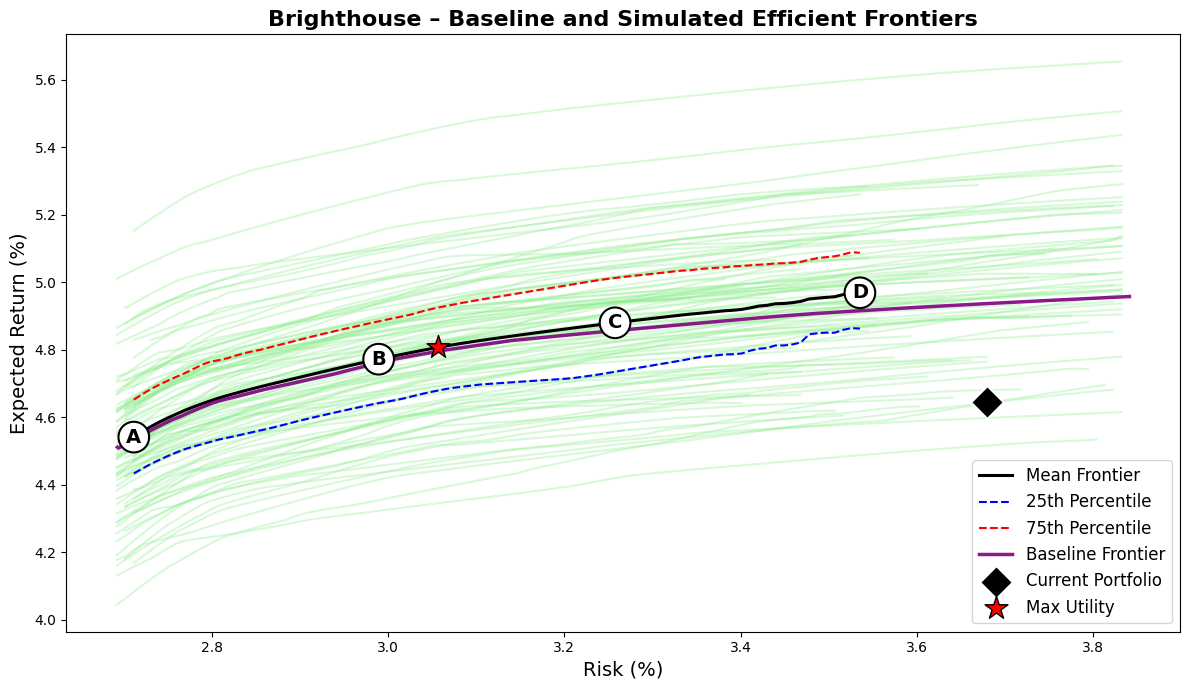

In [12]:
rmse_opt_Brighthouse = robust_optimizer(company_name="Brighthouse")

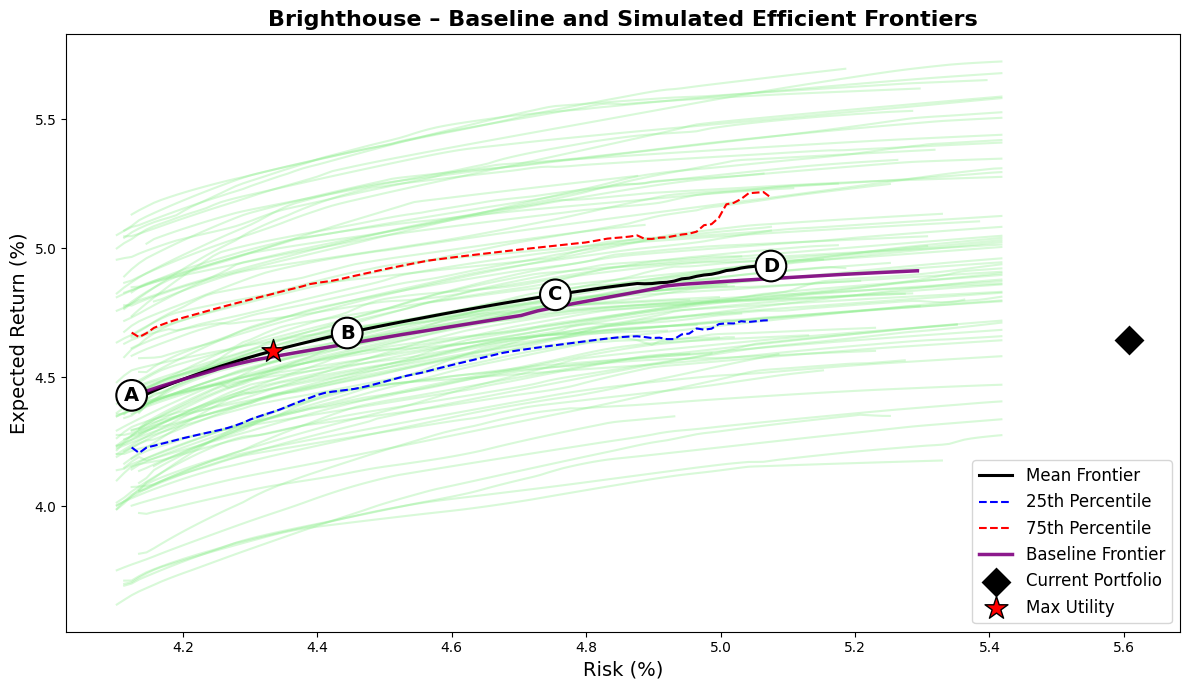

In [13]:
stdev_opt_Brighthouse = robust_optimizer(company_name="Brighthouse", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

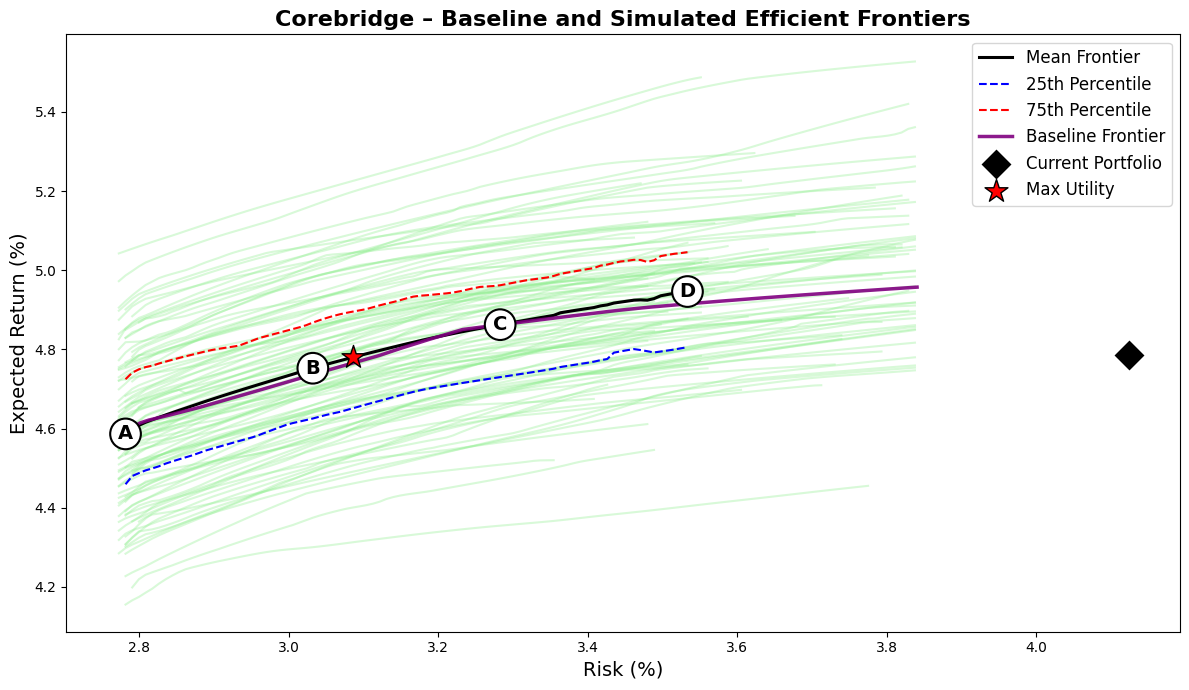

In [14]:
rmse_opt_Corebridge = robust_optimizer(company_name="Corebridge", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=0, export_excel=False)

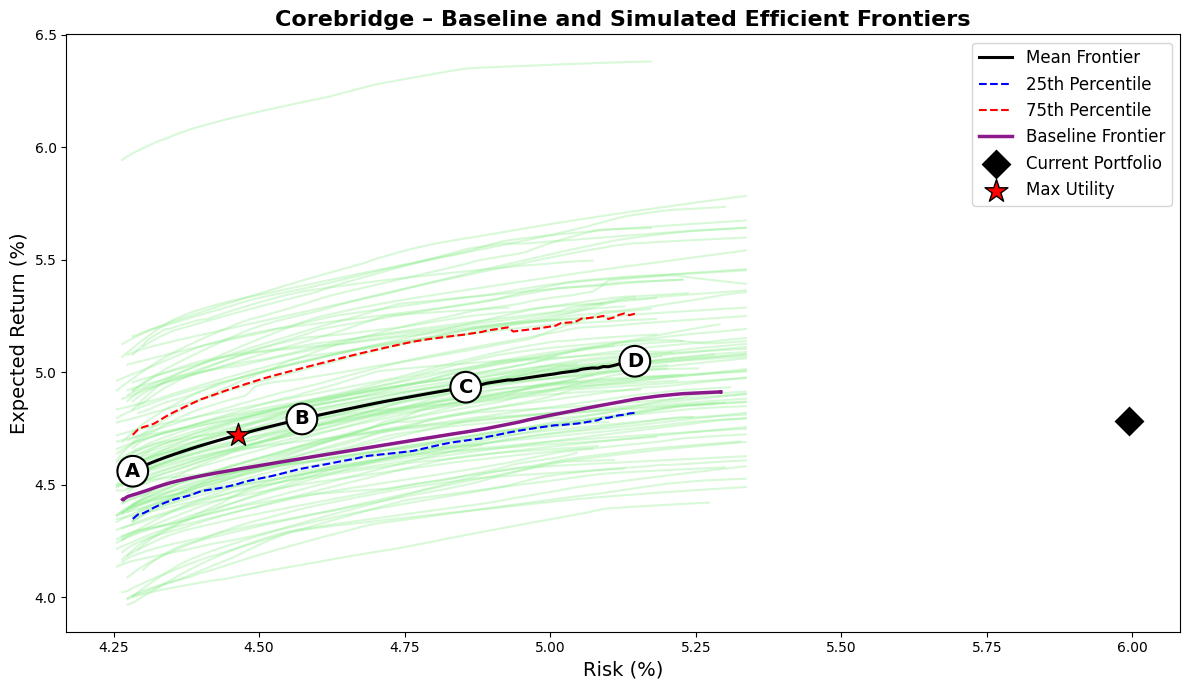

In [15]:
stdev_opt_Corebridge = robust_optimizer(company_name="Corebridge", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

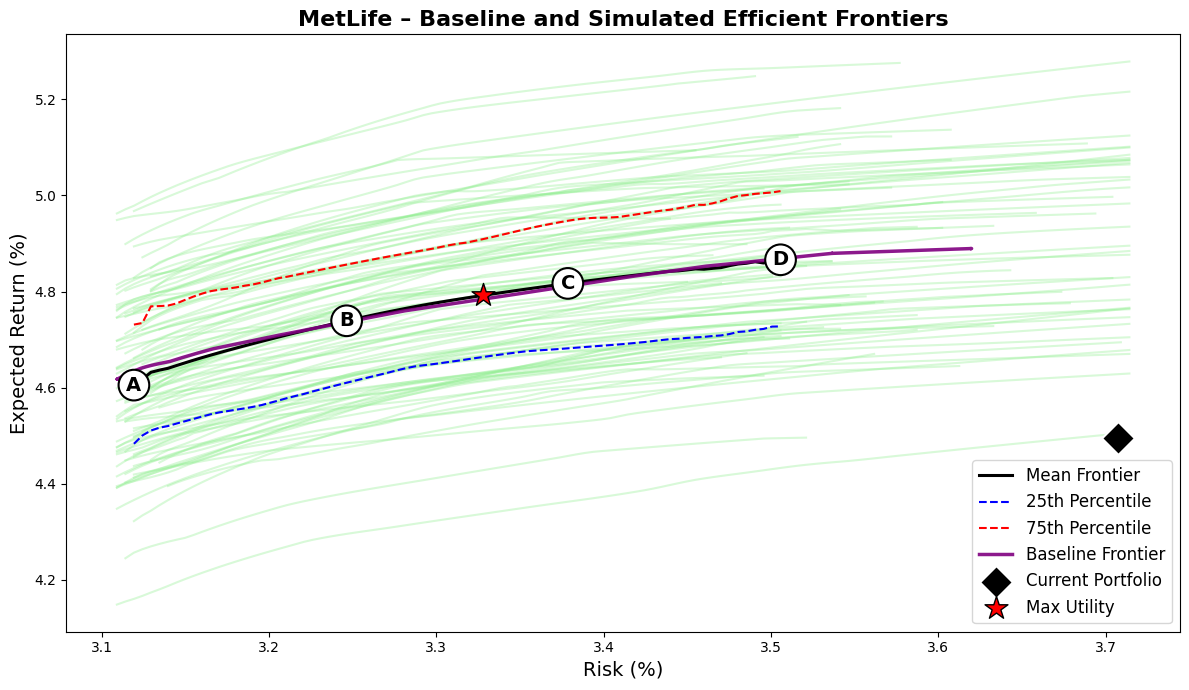

In [16]:
rmse_opt_Metlife = robust_optimizer(company_name="MetLife", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=0, export_excel=False)

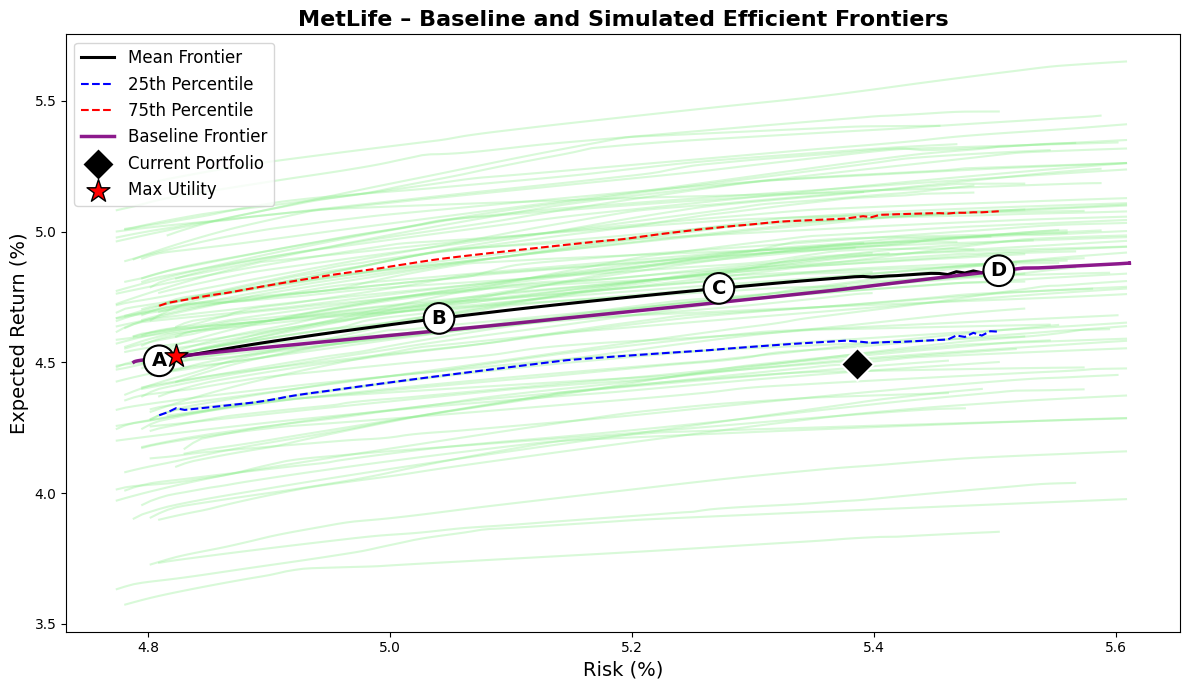

In [17]:
stdev_opt_Metlife = robust_optimizer(company_name="MetLife", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

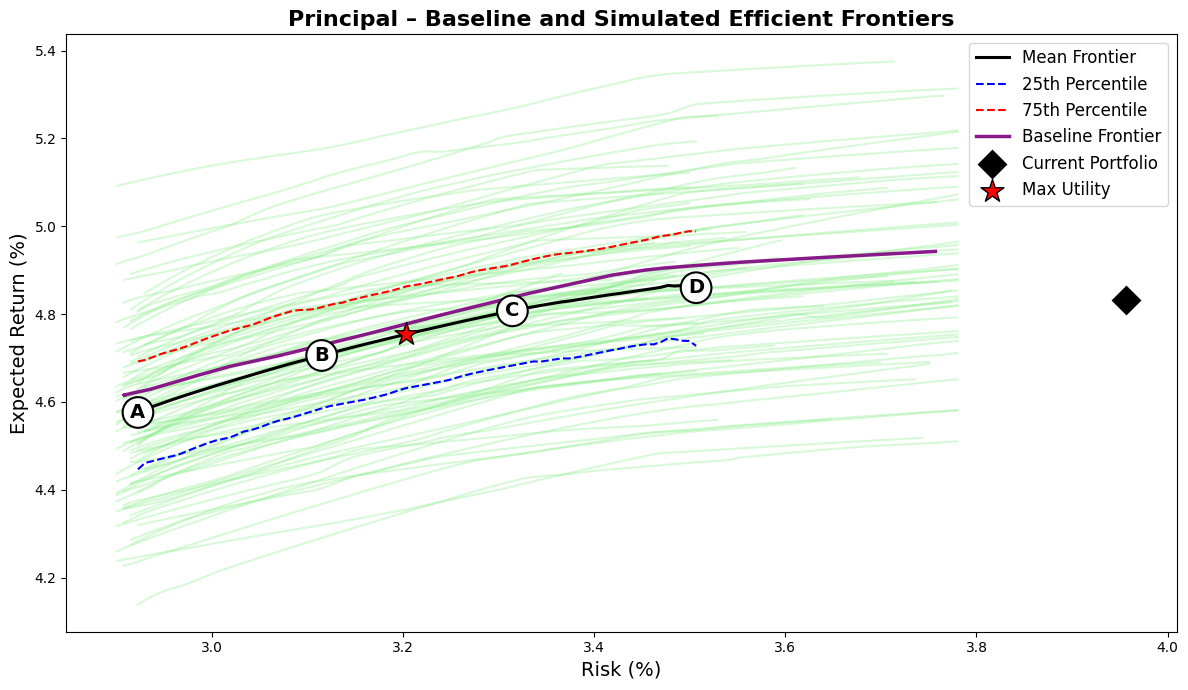

In [18]:
rmse_opt_Principal = robust_optimizer(company_name="Principal", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=0, export_excel=False)

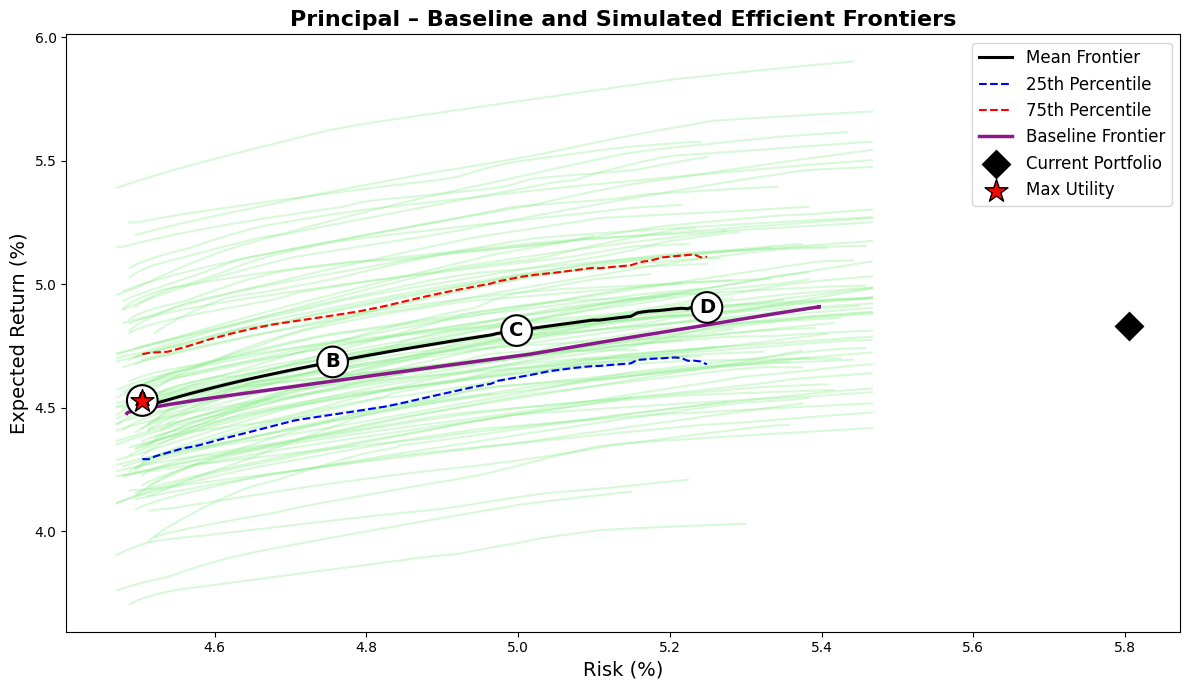

In [19]:
stdev_opt_Principal = robust_optimizer(company_name="Principal", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

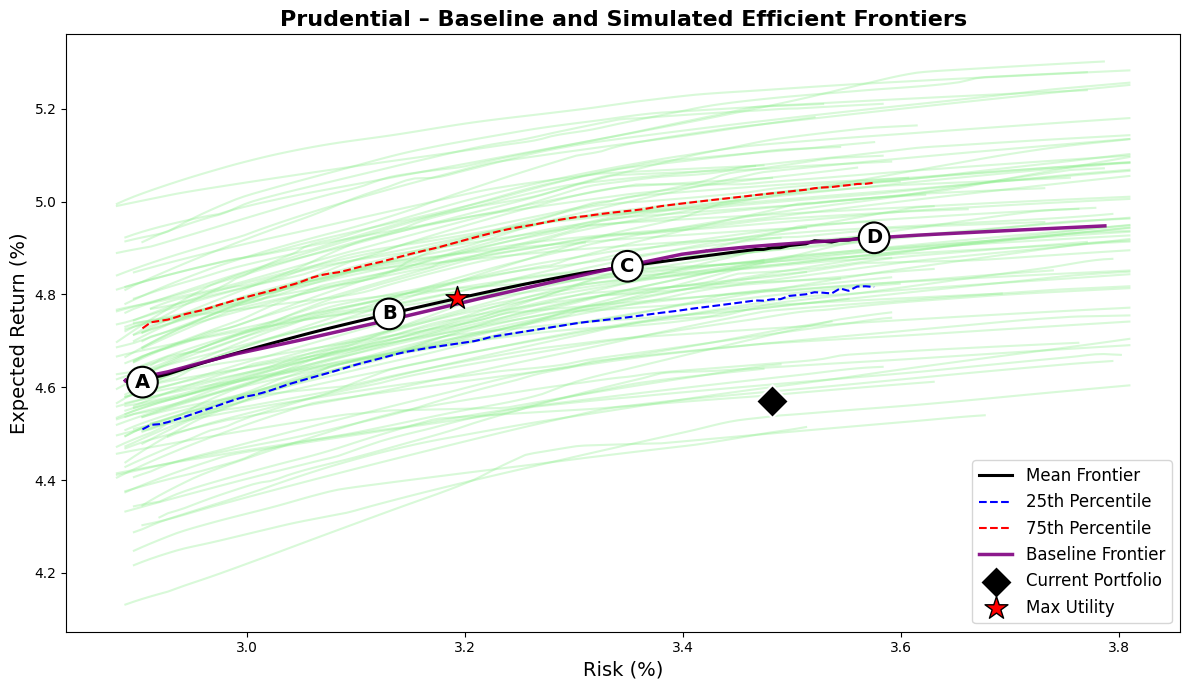

In [20]:
rmse_opt_Prudential = robust_optimizer(company_name="Prudential", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=0, export_excel=False)

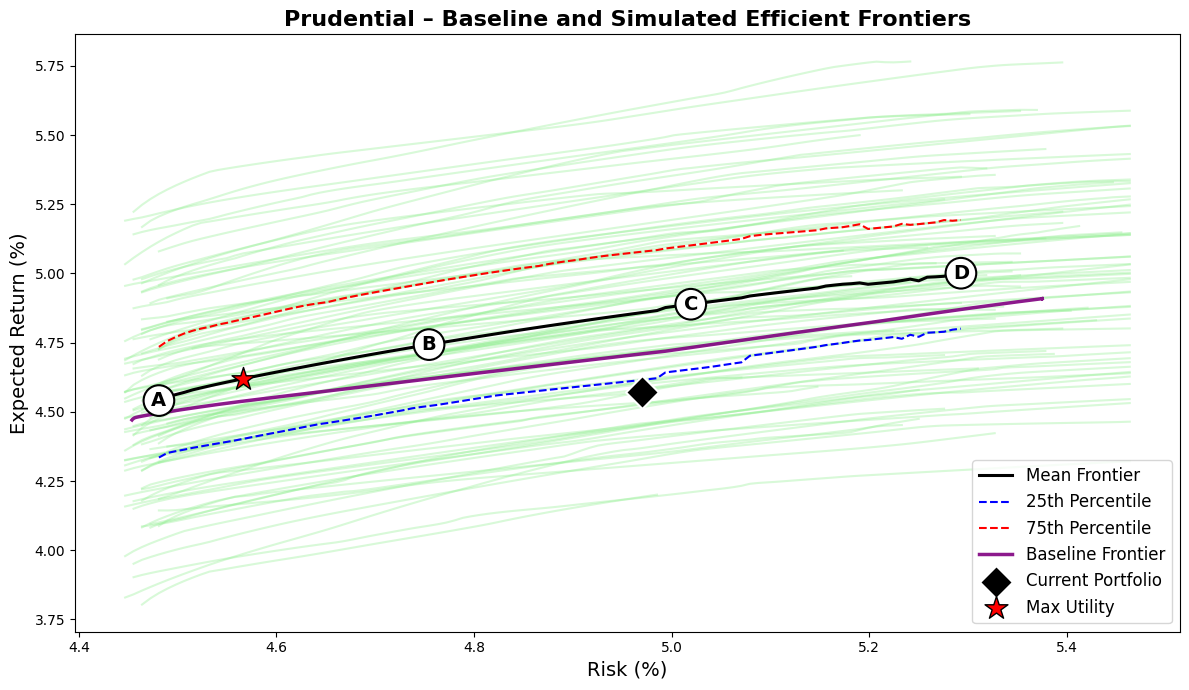

In [21]:
stdev_opt_Prudential = robust_optimizer(company_name="Prudential", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

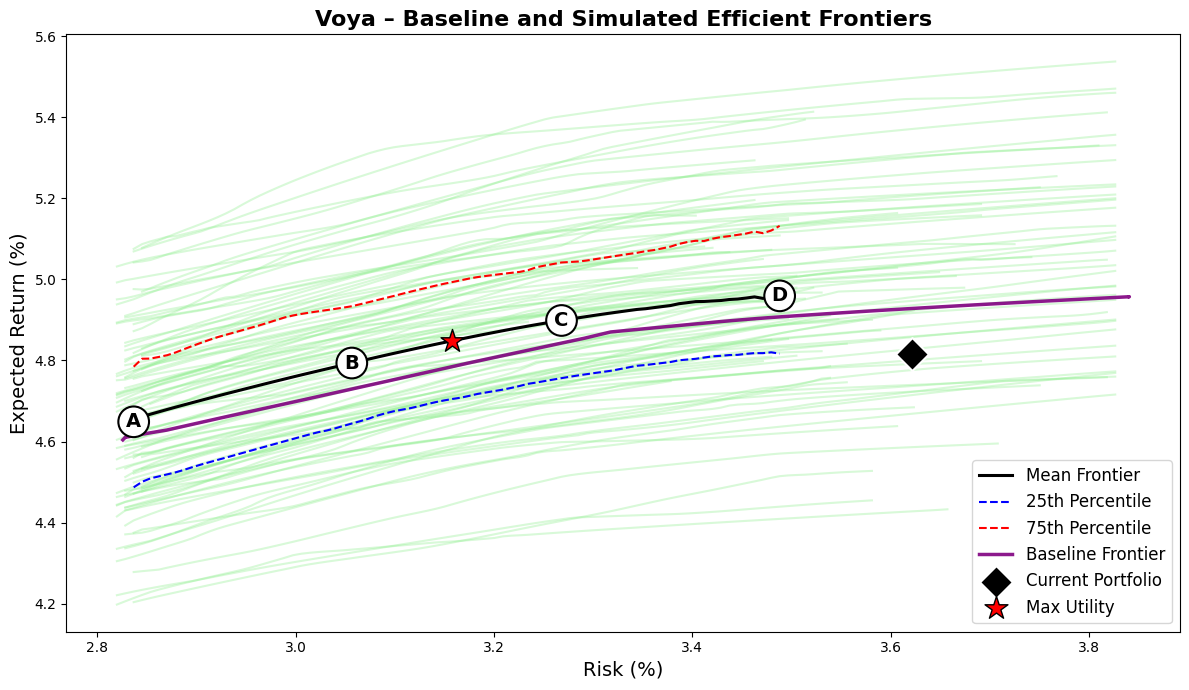

In [22]:
rmse_opt_Voya = robust_optimizer(company_name="Voya", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=0, export_excel=False)

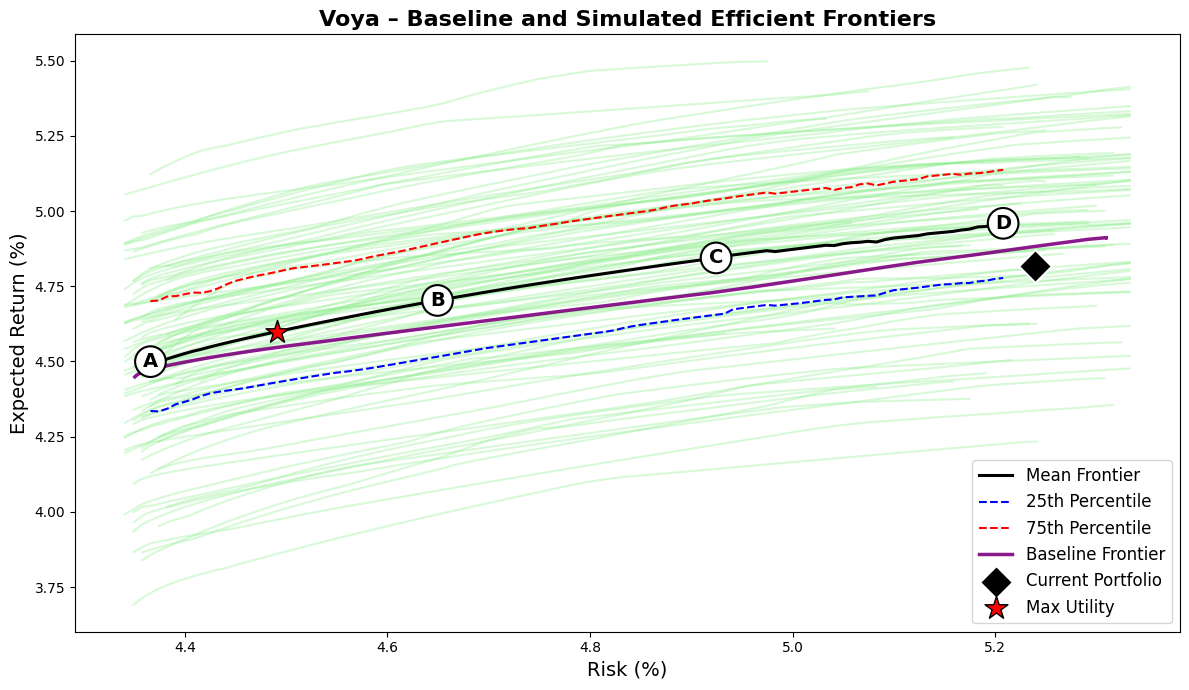

In [23]:
stdev_opt_Voya = robust_optimizer(company_name="Voya", n_scenarios=100, n_points=80, show_plots=True,SHEET_NAME=1, export_excel=False)

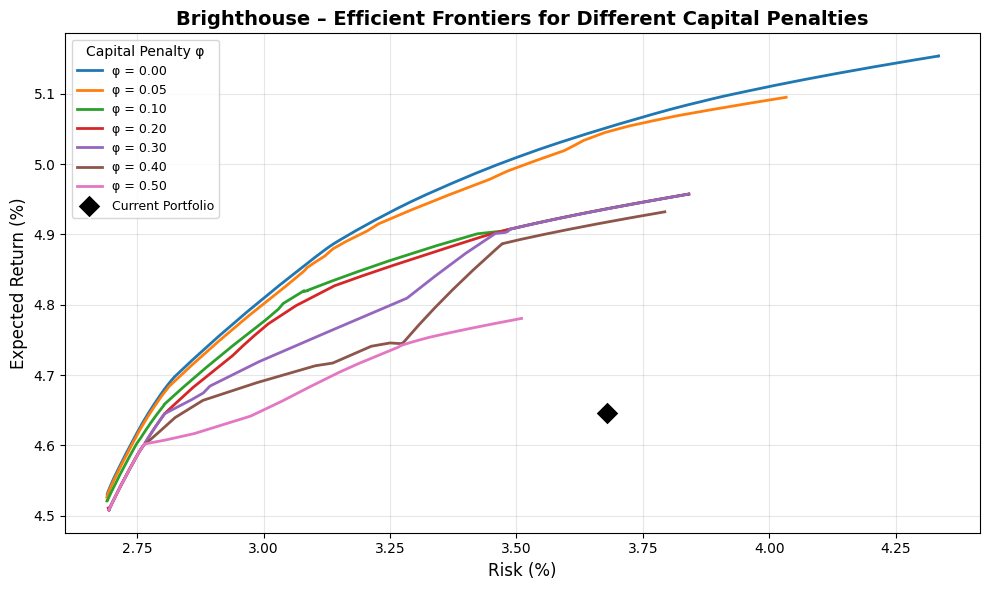

In [24]:
company_name = "Brighthouse"
phis = [0.0,0.05,0.1,0.2,0.3,0.4,0.5]
n_points = 60

# === Load inputs ===
assets, ratings, mu, cap_charge, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
liability_profiles = load_liability_profiles(LIABILITY_BOOK_PATH)
company_liability_duration = float(liability_profiles.loc[company_name, 'Avg_Duration_yrs'])

rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
wmin, wmax = np.full(len(mu), W_MIN_DEFAULT), np.full(len(mu), W_MAX_DEFAULT)

# === Plot efficient frontiers for different φ values ===
plt.figure(figsize=(10, 6))

for phi in phis:
    rets, vols = [], []
    # Sweep λ to trace full frontier
    for lam in np.geomspace(1.0, 50.0, n_points):
        sol = solve_surplus_qp(mu, Sigma, duration, cap_charge, wmin, wmax,
                               assets, ratings, rating_scores,
                               company_liability_duration,
                               surplus_lambda=lam, cap_penalty_phi=phi)
        if sol:
            w_opt, var, ret = sol
            rets.append(ret)
            vols.append(np.sqrt(var))
    if rets:
        plt.plot(100*np.array(vols), 100*np.array(rets), linewidth=2,
                 label=f"φ = {phi:.2f}")

# === Add current portfolio point ===
current_alloc = company_allocations[company_name]
ret_c = float(mu @ current_alloc)
vol_c = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
plt.scatter(100*vol_c, 100*ret_c, c='black', s=150, marker='D',
            edgecolors='white', linewidth=1.3, label='Current Portfolio')

# === Style ===
plt.title(f"{company_name} – Efficient Frontiers for Different Capital Penalties", fontsize=14, fontweight='bold')
plt.xlabel("Risk (%)", fontsize=12)
plt.ylabel("Expected Return (%)", fontsize=12)
plt.legend(title="Capital Penalty φ", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

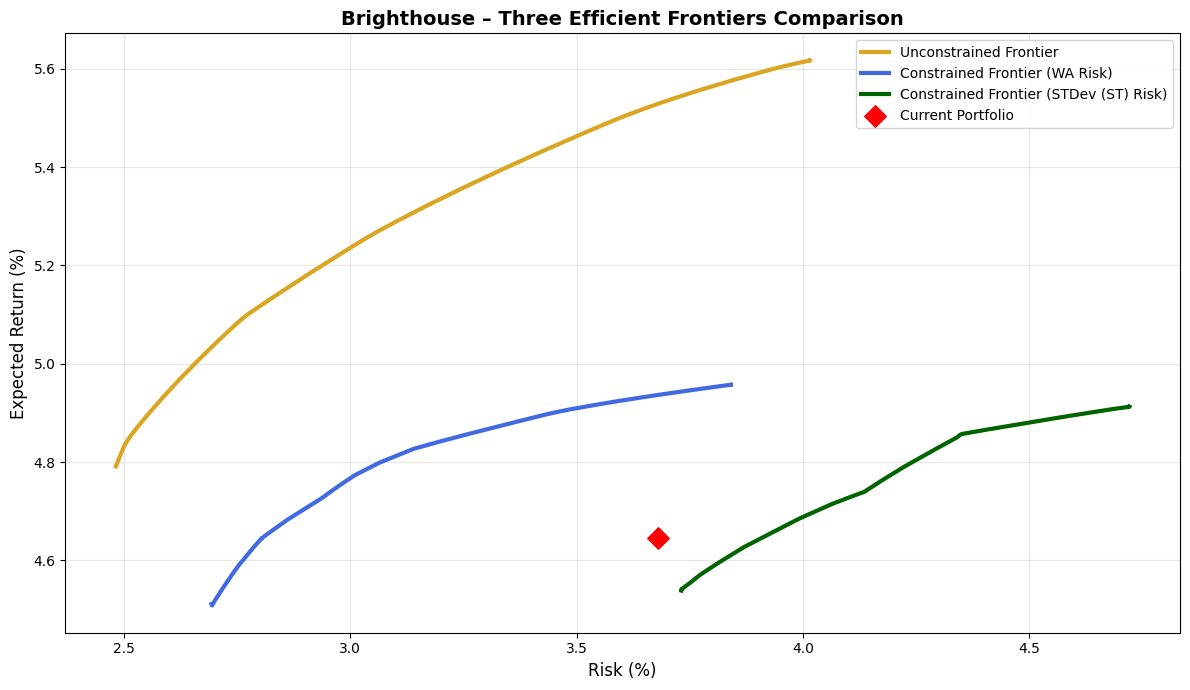

In [28]:
company_name = "Brighthouse"
n_points = 60

# === Load inputs ===
assets, ratings, mu, cap_charge, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
liability_profiles = load_liability_profiles(LIABILITY_BOOK_PATH)
company_liability_duration = float(liability_profiles.loc[company_name, 'Avg_Duration_yrs'])
rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

# === Manual risk measures - StDev %) ===
manual_risk_measures = {
    "US Treasuries, Short/Intermediate": 6.01,
    "US Treasuries, Long": 13.57,
    "US Taxable Munis": 8.21,
    "Global ex-US Government, hedged": 3.99,
    "US Public Corporates IG AAA": 4.45,
    "US Public Corporates IG AA": 5.48,
    "US Public Corporates IG A": 6.27,
    "US Public Corporates IG BBB": 7.23,
    "US Public Corporates, HY Intermediate": 12.46,
    "US Public Corporates, HY Long": 18.04,
    "Global ex-US Corporates, hedged": 5.99,
    "Residential Mortgage-Backed Securities": 8.15,
    "Commercial Mortgage-Backed Securities": 7.74,
    "Asset-Backed Securities": 5.82,
    "Corporate IG Private Placement A": 5.34,
    "Corporate IG Private Placement BBB": 5.70,
    "Corporate HY Private (Leveraged Loans)": 14.43,
    "Residential Mortgage Whole Loans": 2.86,
    "Commercial Mortgage Whole Loans": 13.15,
    "Private Equity": 25.27,
    "Real Estate (via partnerships, equity)": 17.46
}

# === Create new covariance matrix using manual risk measures ===
n_assets = len(assets)
Sigma_manual = np.zeros((n_assets, n_assets))

# Fill diagonal with manual risk measures (convert % to decimal)
for i, asset in enumerate(assets):
    if asset in manual_risk_measures:
        # Convert percentage to decimal and square for variance
        vol_manual = manual_risk_measures[asset] / 100.0
        Sigma_manual[i, i] = vol_manual ** 2
    else:
        # Use original risk measure if not in manual list
        Sigma_manual[i, i] = Sigma[i, i]

# Use original correlation structure but with new volatilities
# Extract correlation matrix from original Sigma
vols_original = np.sqrt(np.diag(Sigma))
vols_manual = np.sqrt(np.diag(Sigma_manual))

# Create correlation matrix
corr_matrix = np.zeros((n_assets, n_assets))
for i in range(n_assets):
    for j in range(n_assets):
        if vols_original[i] > 0 and vols_original[j] > 0:
            corr_matrix[i, j] = Sigma[i, j] / (vols_original[i] * vols_original[j])
        else:
            corr_matrix[i, j] = 1.0 if i == j else 0.0

# Apply new volatilities to correlation matrix
Sigma_manual = corr_matrix * np.outer(vols_manual, vols_manual)

# Ensure positive semi-definite
Sigma_manual = nearest_psd(Sigma_manual)

# === Common settings ===
wmin, wmax = np.full(len(mu), W_MIN_DEFAULT), np.full(len(mu), W_MAX_DEFAULT)
lambdas = np.geomspace(1.0, 50.0, n_points)

# === Frontier helper ===
def compute_frontier(mu, Sigma, duration, cap_charge, wmin, wmax,
                     assets, ratings, rating_scores, dur_target,
                     apply_constraints=True):
    rets, vols = [], []
    for lam in lambdas:
        sol = solve_surplus_qp(mu, Sigma, duration, cap_charge,
                               wmin, wmax, assets, ratings, rating_scores,
                               dur_target,
                               surplus_lambda=lam,
                               cap_penalty_phi=CAP_PENALTY_PHI if apply_constraints else 0.0)
        if sol:
            w_opt, var, ret = sol
            rets.append(ret)
            vols.append(np.sqrt(var))
    return np.array(vols), np.array(rets)

# === Compute all three frontiers ===
# Original constrained frontier
vol_con, ret_con = compute_frontier(mu, Sigma, duration, cap_charge,
                                    wmin, wmax, assets, ratings, rating_scores,
                                    company_liability_duration,
                                    apply_constraints=True)

# Original unconstrained frontier
vol_un, ret_un = compute_frontier(mu, Sigma, duration, cap_charge,
                                  np.full(len(mu), 0.0),  # allow 0–100% per asset
                                  np.full(len(mu), 1.0),
                                  assets, ratings, rating_scores,
                                  company_liability_duration,
                                  apply_constraints=False)

# New frontier with manual risk measures (constrained)
vol_manual, ret_manual = compute_frontier(mu, Sigma_manual, duration, cap_charge,
                                          wmin, wmax, assets, ratings, rating_scores,
                                          company_liability_duration,
                                          apply_constraints=True)

# === Current portfolio point ===
current_alloc = company_allocations[company_name]
ret_c = float(mu @ current_alloc)
vol_c = float(np.sqrt(current_alloc @ Sigma @ current_alloc))

# === Plot ===
plt.figure(figsize=(12,7))
plt.plot(100*vol_un, 100*ret_un, color='goldenrod', linewidth=3, label="Unconstrained Frontier")
plt.plot(100*vol_con, 100*ret_con, color='royalblue', linewidth=3, label="Constrained Frontier (WA Risk)")
plt.plot(100*vol_manual, 100*ret_manual, color='darkgreen', linewidth=3, label="Constrained Frontier (STDev (ST) Risk)")
plt.scatter(100*vol_c, 100*ret_c, color='red', s=120, marker='D', label="Current Portfolio")

plt.title(f"{company_name} – Three Efficient Frontiers Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Risk (%)", fontsize=12)
plt.ylabel("Expected Return (%)", fontsize=12)
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Factor regression and results

In [37]:
"""
Notebook scaffold to:
1) Load monthly factor + asset excess return data
2) Clean/align and standardize factors for regressions
3) Multicollinearity diagnostics (corr, VIF, condition number)
4) Run per-asset OLS with Newey–West (HAC) SEs
   - Heuristics to omit economically-implausible regressors per sleeve
   - Output concise table: coef, t, p, significance, R^2, resid sigma
5) Build two-regime factor covariance matrices based on rolling corr sign
   between ΔL and E (user-specified mapping)
6) Load expected returns (μ) from the separate workbook
7) Persist results to disk for later simulation

Assumptions:
- factors_and_asset_ts.xlsx exists with sheet "factors_and_returns"
  Columns: Date, AL, ΔS, SprIG, E, then 21 asset excess returns (over 1M cash)
- final_inputs.xlsx with sheet "Sheet1":
  A2:A22 = asset names (matching columns), C2:C22 = expected returns (annualized)
- Monthly data, end-of-month.

You can tweak: FILE_PATHS, FACTOR_COLS, OMIT_RULES, HORIZON, ROLLING_WINDOW
"""

# === Config ===
DATA_DIR = Path("./")  # adjust if needed
FACTORS_FILE = DATA_DIR / "factors_and_asset_ts.xlsx"  # if your file is .xls, change here
FACTORS_SHEET = "factors_and_returns"
INPUTS_FILE = DATA_DIR / "final_inputs.xlsx"
INPUTS_SHEET = "rmse"

# Factor column names expected in the Excel sheet (case-sensitive)
FACTOR_COLS = ["ΔL", "ΔS", "SprIG", "E"]
DATE_COL = "Date"

# Use the exact strings from your sheet
AL_COL = FACTOR_COLS[0]   # rate level change column name as it appears in your file
DS_COL = FACTOR_COLS[1]   # slope change column name as it appears in your file

# Rolling window (months) to infer regimes via corr(ΔL, E)
ROLLING_WINDOW = 36

# HAC lags for monthly data (Newey–West)
HAC_LAGS = 6

# Output folder
OUT_DIR = Path("./betas_outputs")
OUT_DIR.mkdir(exist_ok=True)

In [38]:
# === 1) Load factors + asset excess returns ===
raw = pd.read_excel(FACTORS_FILE, sheet_name=FACTORS_SHEET)

# Normalize column names (strip spaces)
raw.columns = [str(c).strip() for c in raw.columns]

# Ensure date is datetime and set index
raw[DATE_COL] = pd.to_datetime(raw[DATE_COL])
df = raw.set_index(DATE_COL).sort_index()

# Split factors and assets
factors = df[FACTOR_COLS].copy()
asset_cols = [c for c in df.columns if c not in FACTOR_COLS]
assets = df[asset_cols].copy()

# Info
print(f"Loaded {factors.shape[0]} months, {factors.shape[1]} factors, {assets.shape[1]} assets.")

Loaded 306 months, 4 factors, 21 assets.


In [39]:
# === 2) Multicollinearity diagnostics on factors (raw units) ===
# Correlation matrix
corr = factors.corr()
print("\nFactor correlation matrix (raw):\n", corr.round(3))

# Condition number (using standardized factors)
X_std = (factors - factors.mean())/factors.std(ddof=0)
U, s, Vt = np.linalg.svd(X_std.dropna(), full_matrices=False)
cond_number = s.max()/s.min()
print(f"\nCondition number (std factors): {cond_number:.2f}")

# VIF (Variance Inflation Factor)
# Add constant for VIF formula convenience
X_vif = sm.add_constant(X_std.dropna())
vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(1, X_vif.shape[1])],
    index=factors.columns,
    name="VIF"
)
print("\nFactor VIF:\n", vif.round(2))


Factor correlation matrix (raw):
           ΔL     ΔS  SprIG      E
ΔL     1.000  0.399 -0.193  0.009
ΔS     0.399  1.000  0.191 -0.018
SprIG -0.193  0.191  1.000 -0.043
E      0.009 -0.018 -0.043  1.000

Condition number (std factors): 1.74

Factor VIF:
 ΔL       1.31
ΔS       1.31
SprIG    1.14
E        1.00
Name: VIF, dtype: float64


In [40]:
# === 3) Standardize factors for regression (z-scores) ===
# We store both raw and standardized versions. Regressions use standardized to make betas comparable.
fac_means = factors.mean()
fac_stds = factors.std(ddof=0).replace(0, np.nan)
factors_z = (factors - fac_means)/fac_stds

In [41]:
# === 4) Heuristics to omit economically-implausible regressors per asset ===
# Define rules as lambdas evaluated on lowercased asset column names
# Edit this mapping as needed to fit your 21 asset labels

RULES = {
    # "equity": {"drop": ["SprIG"]},
}

def factors_to_use(asset_name: str):
    name = asset_name.lower()
    drops = set()
    for key, rule in RULES.items():
        if key in name and "drop" in rule:
            drops.update(rule["drop"])
    return [f for f in FACTOR_COLS if f not in drops]

In [42]:
# === 5) Per-asset OLS with HAC ===
coef_store = {}
resid_sigma = {}
rsq_store = {}
used_factors = {}

# Initialize the results table with assets as rows and factors as columns
results_table = pd.DataFrame(index=assets.columns, columns=FACTOR_COLS + ['R-squared'])
results_table.index.name = 'Asset'

for col in assets.columns:
    y = assets[col].astype(float)
    # Align with factors and drop rows with NA in y or any used factor
    use_cols = factors_to_use(col)
    Xz = factors_z[use_cols]
    aligned = pd.concat([y, Xz], axis=1).dropna()
    if aligned.shape[0] < 60:  # need at least 5 years of monthly data
        print(f"Skipping {col}: insufficient overlapping history ({aligned.shape[0]} months)")
        continue
    y_al = aligned.iloc[:, 0]
    X_al = aligned.iloc[:, 1:]
    X_al = sm.add_constant(X_al)

    model = sm.OLS(y_al, X_al)
    res = model.fit(cov_type='HAC', cov_kwds={'maxlags': HAC_LAGS})

    # Store concise outputs
    params = res.params
    tvals = res.tvalues
    pvals = res.pvalues
    r2 = res.rsquared
    sigma_eps = res.resid.std(ddof=int(res.df_model)+1)

    # --- Drop statistically insignificant factors automatically ---
    SIG_LEVEL = 0.10  # or tighten to 0.05 depending on your cutoff
    sig_factors = [f for f in FACTOR_COLS if f in pvals.index and pvals[f] < SIG_LEVEL]

    # Only keep significant betas for simulation
    coef_store[col] = {f: params[f] for f in sig_factors}
    used_factors[col] = sig_factors

    rsq_store[col] = r2
    resid_sigma[col] = sigma_eps
    used_factors[col] = use_cols

    # Fill the results table with formatted betas and significance stars
    for factor in FACTOR_COLS:
        if factor in params.index:
            beta = params[factor]
            pval = pvals[factor]
            # Format: beta with 3 decimals + significance stars
            sig_stars = '***' if pval < 0.01 else '**' if pval < 0.05 else ('*' if pval < 0.10 else '')
            results_table.loc[col, factor] = f"{beta:.3f}{sig_stars}"
        else:
            results_table.loc[col, factor] = "N/A"
    
    # Add R-squared with 3 decimals
    results_table.loc[col, 'R-squared'] = f"{r2:.3f}"

# Remove rows where asset was skipped (all NaN)
results_table = results_table.dropna(how='all')

# Create separate dataframes for saving
rsq_df = pd.DataFrame({"asset": list(rsq_store.keys()), "R2": list(rsq_store.values())})
resid_df = pd.DataFrame({"asset": list(resid_sigma.keys()), "sigma_eps": list(resid_sigma.values())})

print("significance stars (* p<0.10, ** p<0.05, *** p<0.01)")
display(results_table)

# Persist outputs
results_table.to_csv(OUT_DIR/"asset_betas_hac.csv")
rsq_df.to_csv(OUT_DIR/"asset_r2.csv", index=False)
resid_df.to_csv(OUT_DIR/"asset_resid_sigma.csv", index=False)
with open(OUT_DIR/"asset_betas_hac.json", "w") as f:
    json.dump(coef_store, f, indent=2)
with open(OUT_DIR/"asset_used_factors.json", "w") as f:
    json.dump(used_factors, f, indent=2)

significance stars (* p<0.10, ** p<0.05, *** p<0.01)


ΔL         ΔS  \
Asset                                                                 
US Treasuries, Short/Intermediate              -0.010***   0.002***   
US Treasuries, Long                            -0.029***  -0.006***   
US Taxable Munis                               -0.010***      0.000   
Global ex-US Government, hedged                -0.008***      0.000   
US Public Corporates IG AAA                    -0.011***   0.002***   
US Public Corporates IG AA                     -0.014***   0.002***   
US Public Corporates IG A                      -0.015***   0.002***   
US Public Corporates IG BBB                    -0.015***   0.003***   
US Public Corporates, HY Intermediate          -0.004***   0.004***   
US Public Corporates, HY Long                  -0.010***   0.006***   
Global ex-US Corporates, hedged                -0.011***   0.002***   
Residential Mortgage-Backed Securities (RMBS)  -0.010***   0.003***   
Commercial Mortgage-Backed Securities (CMBS)   -0.011***   0.003***   
Asset-Backed Securities (ABS)                  -0.006***   0.003***   
Corporate IG Private Placement A               -0.003***   0.002***   
Corporate IG Private Placement BBB             -0.002***   0.002***   
Corporate HY Private (Leveraged Loans)          0.001***   0.002***   
Residential Mortgage Whole Loans               -0.013***     0.002*   
Commercial Mortgage Whole Loans                -0.009***    0.003**   
Private Equity                                     0.002     -0.003   
Real Estate (via partnerships, equity)             0.000     -0.004   

                                                   SprIG         E R-squared  
Asset                                                                         
US Treasuries, Short/Intermediate                -0.000*    -0.000     0.964  
US Treasuries, Long                               -0.000     0.000     0.897  
US Taxable Munis                               -0.006***    -0.001     0.578  
Global ex-US Government, hedged                 -0.002**    -0.000     0.642  
US Public Corporates IG AAA                    -0.002***    -0.000     0.921  
US Public Corporates IG AA                     -0.008***    -0.000     0.920  
US Public Corporates IG A                      -0.013***     0.000     0.935  
US Public Corporates IG BBB                    -0.017***    -0.000     0.908  
US Public Corporates, HY Intermediate          -0.023***    -0.000     0.682  
US Public Corporates, HY Long                  -0.031***     0.000     0.722  
Global ex-US Corporates, hedged                -0.011***    -0.000     0.910  
Residential Mortgage-Backed Securities (RMBS)  -0.003***   -0.001*     0.722  
Commercial Mortgage-Backed Securities (CMBS)   -0.012***     0.001     0.359  
Asset-Backed Securities (ABS)                  -0.006***     0.000     0.553  
Corporate IG Private Placement A               -0.004***  0.001***     0.248  
Corporate IG Private Placement BBB             -0.004***   0.001**     0.215  
Corporate HY Private (Leveraged Loans)         -0.018***    -0.002     0.880  
Residential Mortgage Whole Loans               -0.004***    -0.001     0.787  
Commercial Mortgage Whole Loans                -0.012***     0.001     0.327  
Private Equity                                    -0.001  0.053***     0.803  
Real Estate (via partnerships, equity)            -0.002  0.036***     0.524

In [43]:
# === 6) Two-regime factor covariance matrices ===
# Regime classification by rolling corr sign between ΔL (AL) and E in RAW units (not standardized)
# rolling correlation between AL (rate level change) and E (equity excess return)
roll_corr = factors[AL_COL].rolling(ROLLING_WINDOW).corr(factors["E"])  # Series aligned to index
regime_series = pd.Series(index=factors.index, dtype="object")
# User mapping (per user note):
# Normal regime: corr(AL, E) > 0 ; Inflationary (positive stock-bond corr) regime: corr(AL, E) < 0
regime_series.loc[roll_corr > 0] = "Normal_PositiveCorr(AL,E)"
regime_series.loc[roll_corr <= 0] = "Inflationary_NegativeCorr(AL,E)"

# Attach regime to factor rows and drop rows without regime label (due to initial NA window)
fac_reg = factors.copy()
fac_reg["Regime"] = regime_series
fac_reg = fac_reg.dropna(subset=["Regime"])  # drops early months without rolling window

cov_all = factors.cov()

cov_normal = fac_reg[fac_reg["Regime"] == "Normal_PositiveCorr(AL,E)"][FACTOR_COLS].cov()
cov_infl = fac_reg[fac_reg["Regime"] == "Inflationary_NegativeCorr(AL,E)"][FACTOR_COLS].cov()

# Persist covariances
cov_all.to_csv(OUT_DIR/"factor_cov_overall.csv")
cov_normal.to_csv(OUT_DIR/"factor_cov_normal.csv")
cov_infl.to_csv(OUT_DIR/"factor_cov_inflationary.csv")

In [44]:
# === 7) Load expected returns (μ) ===
mu_df = pd.read_excel(INPUTS_FILE, sheet_name=INPUTS_SHEET, header=None)
# Expecting: Column A: names (rows 2..22), Column C: expected returns
mu_names = mu_df.iloc[1:22, 0].astype(str).tolist()
mu_vals = mu_df.iloc[1:22, 2].astype(float).tolist()
mu = pd.Series(mu_vals, index=mu_names, name="mu")

# Try to align μ with asset column names; create a mapping by exact match or fuzzy lower()
mu_map = {}
for col in assets.columns:
    # exact match first
    if col in mu.index:
        mu_map[col] = mu.loc[col]
    else:
        # fallback: case-insensitive match on stripped strings
        matches = [idx for idx in mu.index if idx.strip().lower() == col.strip().lower()]
        if matches:
            mu_map[col] = mu.loc[matches[0]]
        else:
            mu_map[col] = np.nan

mu_series = pd.Series(mu_map).rename("mu")
print("\nμ alignment coverage: ", mu_series.notna().mean())
if mu_series.isna().any():
    print("Missing μ for:", list(mu_series[mu_series.isna()].index))

mu_series.to_csv(OUT_DIR/"asset_mu.csv")


μ alignment coverage:  1.0


In [45]:
# === 8) Save factor standardization params for later un/standardization ===
std_params = {
    "means": fac_means.to_dict(),
    "stds": fac_stds.to_dict(),
    "factor_cols": FACTOR_COLS
}
with open(OUT_DIR/"factor_standardization.json", "w") as f:
    json.dump(std_params, f, indent=2)

print("All artifacts written to:", OUT_DIR.resolve())

All artifacts written to: C:\Users\gigan\OneDrive\Desktop\NYU\Fall 2025\Capstone\Optimization\betas_outputs


In [46]:
# ==============================================
# 9) Monte Carlo simulator + H1–H3 evaluation
# ==============================================
"""
What this block adds:
- Clean helpers to simulate two-regime factor shocks and portfolio/liability paths.
- Uses *significance-filtered* betas from `coef_store` (only factors you kept earlier).
- Functions to evaluate a single portfolio and compare two portfolios for H1–H3:
  * H1 (Surplus performance): median surplus CAGR (10y)
  * H2 (Shortfall risk): P(Surplus < 0) and P(Surplus CAGR < liab discount rate)
  * H3 (RBC efficiency): Surplus per unit RBC

How to use:
- Provide portfolio weights (dict asset -> weight) from any optimizer.
- Provide RBC charges (dict asset -> RBC charge, e.g., 0.10 = 10%).
- Provide an annual liability discount rate for H2 (e.g., 0.04).

Entry points:
- results = evaluate_portfolio(weights, liab_discount_rate=0.04, RBC_charges=RBC_charges)
- comparison = compare_portfolios(weights_rmse, weights_vol, liab_discount_rate=0.04, RBC_charges=RBC_charges)

Notes:
- Assumes `coef_store`, `fac_stds`, `resid_sigma`, `mu_series`, `cov_normal`, `cov_infl`, `AL_COL`, `DS_COL`, `FACTOR_COLS`, `OUT_DIR`
  already exist from earlier steps.
"""

# --- Helper: convert standardized betas to raw-space betas ---
def convert_betas_to_raw(coef_store: dict, fac_stds: pd.Series) -> dict:
    """
    coef_store: {asset: {factor: beta_z, ...}, ...}  (only significant factors expected)
    fac_stds: Series of factor std in RAW units (same units used to build covariances)
    """
    beta_raw = {}
    for asset, betas in coef_store.items():
        b = {}
        for f, val in betas.items():
            if f in fac_stds and pd.notna(fac_stds[f]) and fac_stds[f] != 0:
                b[f] = val / fac_stds[f]
        beta_raw[asset] = b
    return beta_raw

beta_raw = convert_betas_to_raw(coef_store, fac_stds)
with open(OUT_DIR/"asset_betas_rawspace.json", "w") as f:
    json.dump(beta_raw, f, indent=2)

# --- Regime probabilities from history (based on available rows) ---
num_normal = (fac_reg["Regime"] == "Normal_PositiveCorr(AL,E)").sum()
num_infl   = (fac_reg["Regime"] == "Inflationary_NegativeCorr(AL,E)").sum()
p_normal   = num_normal / max(1, (num_normal + num_infl))
p_infl     = 1 - p_normal
print(f"Regime probabilities: Normal={p_normal:.2%}, Inflationary={p_infl:.2%}")

# --- Ensure covariance matrices are PSD for sampling ---
def psd_adjust(cov: pd.DataFrame, eps: float = 1e-10) -> pd.DataFrame:
    vals, vecs = np.linalg.eigh(cov.values)
    vals[vals < eps] = eps
    cov_psd = (vecs @ np.diag(vals) @ vecs.T)
    return pd.DataFrame(cov_psd, index=cov.index, columns=cov.columns)

covN = psd_adjust(cov_normal)
covI = psd_adjust(cov_infl)

# --- Core simulator ---
def simulate_paths(weights: dict,
                   N_paths: int = 10000,
                   T_months: int = 120,
                   A0: float = 1.0,
                   L0: float = 1.0,
                   mu_series: pd.Series = mu_series,
                   beta_raw: dict = beta_raw,
                   resid_sigma: dict = resid_sigma,
                   factor_cols: list = FACTOR_COLS,
                   cov_normal: pd.DataFrame = covN,
                   cov_infl: pd.DataFrame = covI,
                   p_normal: float = p_normal,
                   liability_params: dict = None,
                   rng: np.random.Generator = np.random.default_rng(42),
                   return_paths: bool = False):
    """
    Simulates joint monthly factors (two-regime) and computes portfolio A/L/surplus levels.

    Returns a dict with arrays (per path) and summary vectors:
      - A_end, L_end, S_end
      - A_CAGR, L_CAGR, S_CAGR_proxy (=(A/L)^(1/years)-1)
      - shortfall_end (bool: S_end<0)
      - factor_order, weights, params
      - Optional: rA_hist, rL_hist, reg_hist if return_paths=True
    """
    # Prepare
    years = T_months / 12
    fac_dim = len(factor_cols)
    asset_list = list(weights.keys())
    if len(asset_list) == 0:
        raise ValueError("No assets provided in weights.")

    # Assemble matrices
    B = np.zeros((len(asset_list), fac_dim))
    sig_eps = np.zeros(len(asset_list))
    mu_m = np.zeros(len(asset_list))

    for i, a in enumerate(asset_list):
        mu_ann = mu_series.get(a, np.nan)
        if pd.isna(mu_ann):
            raise ValueError(f"Missing μ for asset: {a}")
        mu_m[i] = (1 + mu_ann) ** (1/12) - 1

        br = beta_raw.get(a, {})
        B[i, :] = [br.get(f, 0.0) for f in factor_cols]

        if a not in resid_sigma:
            raise ValueError(f"Missing residual sigma for asset: {a}")
        sig_eps[i] = float(resid_sigma[a])

    w = np.array([weights[a] for a in asset_list], dtype=float)
    if w.sum() == 0:
        raise ValueError("Weights sum to zero.")
    w = w / w.sum()

    # Cholesky
    cholN = np.linalg.cholesky(cov_normal.values)
    cholI = np.linalg.cholesky(cov_infl.values)

    # Storage
    A = np.full((N_paths,), A0, dtype=float)
    L = np.full((N_paths,), L0, dtype=float)

    if return_paths:
        rA_hist = np.zeros((N_paths, T_months))
        rL_hist = np.zeros((N_paths, T_months))
        reg_hist = np.zeros((N_paths, T_months), dtype=int)
    else:
        rA_hist = rL_hist = reg_hist = None

    # Liability params (tunable)
    if liability_params is None:
        liability_params = {
            "accrual": 0.04/12,    # 4% annual accrual
            "beta_AL": -0.08,      # sensitivity to AL (units = your raw AL units)
            "beta_dS": -0.01       # sensitivity to ΔS
        }
    accr = float(liability_params["accrual"])
    bL   = float(liability_params["beta_AL"])
    bS   = float(liability_params["beta_dS"])

    idx_AL = factor_cols.index(AL_COL)
    idx_dS = factor_cols.index(DS_COL) if DS_COL in factor_cols else factor_cols.index("dS")

    # Simulate
    for t in range(T_months):
        is_normal = rng.uniform(size=N_paths) < p_normal
        # factors (RAW units)
        zN = rng.standard_normal((N_paths, fac_dim)) @ cholN.T
        zI = rng.standard_normal((N_paths, fac_dim)) @ cholI.T
        F  = np.where(is_normal[:, None], zN, zI)

        # assets
        eps      = rng.standard_normal((N_paths, len(asset_list))) * sig_eps
        r_assets = (F @ B.T) + eps + mu_m
        r_port   = (r_assets * w).sum(axis=1)

        # liability
        r_L = accr + bL * F[:, idx_AL] + bS * F[:, idx_dS]

        # update levels
        A *= (1 + r_port)
        L *= (1 + r_L)

        if return_paths:
            rA_hist[:, t] = r_port
            rL_hist[:, t] = r_L
            reg_hist[:, t] = is_normal.astype(int)

    S_end   = A - L
    A_CAGR  = (A / A0) ** (1/years) - 1
    L_CAGR  = (L / L0) ** (1/years) - 1
    S_CAGR  = (A / L) ** (1/years) - 1  # proxy surplus CAGR vs liabilities
    shortfall_end = (S_end < 0)

    results = {
        "A_end": A, "L_end": L, "S_end": S_end,
        "A_CAGR": A_CAGR, "L_CAGR": L_CAGR, "S_CAGR_proxy": S_CAGR,
        "shortfall_end": shortfall_end,
        "weights": dict(zip(asset_list, w)),
        "factor_order": factor_cols,
        "params": {
            "N_paths": N_paths, "T_months": T_months,
            "liability_params": liability_params, "p_normal": p_normal
        }
    }
    if return_paths:
        results.update({"rA_hist": rA_hist, "rL_hist": rL_hist, "reg_hist": reg_hist})
    return results

# --- Metrics + H1–H3 helpers ---
def summarize_distribution(x: np.ndarray, pct_list=(5, 25, 50, 75, 95)) -> dict:
    quants = np.percentile(x, pct_list)
    return {f"p{p}": float(q) for p, q in zip(pct_list, quants)}

def portfolio_RBC(weights: dict, charges: dict) -> float:
    """Simple RBC add-up: sum_i w_i * RBC_i. Provide charges as decimals (e.g., 0.10 = 10%)."""
    return float(sum(weights.get(a, 0.0) * charges.get(a, 0.0) for a in weights))

def evaluate_portfolio(weights: dict,
                       liab_discount_rate: float,
                       RBC_charges: dict = None,
                       N_paths: int = 10000,
                       T_months: int = 120,
                       return_paths: bool = False,
                       save_prefix: str = None,
                       rng_seed: int = 42):
    """
    Runs simulation and computes:
      - H1 metric: median S_CAGR_proxy
      - H2 metrics: P(S_end<0) and P(S_CAGR_proxy < liab_discount_rate)
      - H3 metric: Surplus per unit RBC (median S_CAGR_proxy / portfolio RBC)
    """
    results = simulate_paths(weights=weights, N_paths=N_paths, T_months=T_months,
                             rng=np.random.default_rng(rng_seed),
                             return_paths=return_paths)

    # H1: Surplus performance (median surplus CAGR over horizon)
    s_cagr = results["S_CAGR_proxy"]
    h1_median_cagr = float(np.median(s_cagr))

    # H2: Shortfall risk
    h2_prob_Sneg = float(results["shortfall_end"].mean())
    h2_prob_CAGR_below_discount = float((s_cagr < liab_discount_rate).mean())

    # H3: RBC efficiency
    rbc_val = portfolio_RBC(results["weights"], RBC_charges) if RBC_charges else np.nan
    h3_surplus_per_RBC = float(h1_median_cagr / rbc_val) if (RBC_charges and rbc_val > 0) else np.nan

    # Summaries
    summary = {
        "H1_median_Surplus_CAGR": h1_median_cagr,
        "H2_prob_Surplus_lt_0": h2_prob_Sneg,
        "H2_prob_SurplusCAGR_lt_Discount": h2_prob_CAGR_below_discount,
        "H3_SurplusPerRBC": h3_surplus_per_RBC,
        "A_CAGR_summary": summarize_distribution(results["A_CAGR"]),
        "L_CAGR_summary": summarize_distribution(results["L_CAGR"]),
        "S_CAGR_summary": summarize_distribution(s_cagr),
        "S_end_summary": summarize_distribution(results["S_end"]),
        "weights": results["weights"],
        "params": results["params"],
        "RBC_value": rbc_val
    }

    # Optional persistence
    if save_prefix is not None:
        with open(OUT_DIR/f"{save_prefix}_summary.json", "w") as f:
            json.dump(summary, f, indent=2)
        if return_paths:
            np.save(OUT_DIR/f"{save_prefix}_rA_hist.npy", results["rA_hist"])
            np.save(OUT_DIR/f"{save_prefix}_rL_hist.npy", results["rL_hist"])
            np.save(OUT_DIR/f"{save_prefix}_reg_hist.npy", results["reg_hist"])

    return {"results": results, "summary": summary}

def compare_portfolios(weights_rmse: dict,
                       weights_vol: dict,
                       liab_discount_rate: float,
                       RBC_charges: dict,
                       N_paths: int = 10000,
                       T_months: int = 120,
                       rng_seed: int = 42,
                       save_prefix: str = None):
    """
    Runs both portfolios under the *same* random seed (for fair comparison) and reports H1–H3 deltas.
    """
    eva_rmse = evaluate_portfolio(weights_rmse, liab_discount_rate, RBC_charges,
                                  N_paths=N_paths, T_months=T_months,
                                  return_paths=False, save_prefix=(f"{save_prefix}_RMSE" if save_prefix else None),
                                  rng_seed=rng_seed)
    eva_vol  = evaluate_portfolio(weights_vol, liab_discount_rate, RBC_charges,
                                  N_paths=N_paths, T_months=T_months,
                                  return_paths=False, save_prefix=(f"{save_prefix}_VOL" if save_prefix else None),
                                  rng_seed=rng_seed)

    s1 = eva_rmse["summary"]; s2 = eva_vol["summary"]
    comparison = {
        "H1_SurplusCAGR_RMSE": s1["H1_median_Surplus_CAGR"],
        "H1_SurplusCAGR_VOL":  s2["H1_median_Surplus_CAGR"],
        "H1_Difference_RMSE_minus_VOL": s1["H1_median_Surplus_CAGR"] - s2["H1_median_Surplus_CAGR"],
        "H2_P(S_end<0)_RMSE": s1["H2_prob_Surplus_lt_0"],
        "H2_P(S_end<0)_VOL":  s2["H2_prob_Surplus_lt_0"],
        "H2_Diff_PctPts":     (s1["H2_prob_Surplus_lt_0"] - s2["H2_prob_Surplus_lt_0"]),
        "H2_P(S_CAGR<Disc)_RMSE": s1["H2_prob_SurplusCAGR_lt_Discount"],
        "H2_P(S_CAGR<Disc)_VOL":  s2["H2_prob_SurplusCAGR_lt_Discount"],
        "H2_Diff_PctPts_CAGRvsDisc": (s1["H2_prob_SurplusCAGR_lt_Discount"] - s2["H2_prob_SurplusCAGR_lt_Discount"]),
        "H3_SurplusPerRBC_RMSE": s1["H3_SurplusPerRBC"],
        "H3_SurplusPerRBC_VOL":  s2["H3_SurplusPerRBC"],
        "H3_Difference":         (s1["H3_SurplusPerRBC"] - s2["H3_SurplusPerRBC"]),
        "liab_discount_rate_used": liab_discount_rate
    }

    if save_prefix is not None:
        with open(OUT_DIR/f"{save_prefix}_comparison.json", "w") as f:
            json.dump(comparison, f, indent=2)

    # Print concise readout for notebook
    print("\n=== (Surplus performance) ===")
    print(f"Median Surplus CAGR: RMSE={comparison['H1_SurplusCAGR_RMSE']:.2%}  |  VOL={comparison['H1_SurplusCAGR_VOL']:.2%}  "
          f"|  Δ={comparison['H1_Difference_RMSE_minus_VOL']:.2%}")
    print("=== (Shortfall risk) ===")
    print(f"P(Surplus<0):       RMSE={comparison['H2_P(S_end<0)_RMSE']:.2%}  |  VOL={comparison['H2_P(S_end<0)_VOL']:.2%}  "
          f"|  Δ={comparison['H2_Diff_PctPts']:.2%}")
    print(f"P(SurplusCAGR<Disc):RMSE={comparison['H2_P(S_CAGR<Disc)_RMSE']:.2%} |  VOL={comparison['H2_P(S_CAGR<Disc)_VOL']:.2%} "
          f"|  Δ={comparison['H2_Diff_PctPts_CAGRvsDisc']:.2%}")
    print("=== (RBC efficiency) ===")
    print(f"Surplus/RBC:        RMSE={comparison['H3_SurplusPerRBC_RMSE']:.2f} |  VOL={comparison['H3_SurplusPerRBC_VOL']:.2f} "
          f"|  Δ={comparison['H3_Difference']:.2f}")
    
    # === Visualization Section ===
    # Re-run with full paths (we only stored summaries above)
    eva_rmse_paths = evaluate_portfolio(weights_rmse, liab_discount_rate, RBC_charges,
                                        N_paths=N_paths, T_months=T_months,
                                        return_paths=True, rng_seed=rng_seed)
    eva_vol_paths  = evaluate_portfolio(weights_vol, liab_discount_rate, RBC_charges,
                                        N_paths=N_paths, T_months=T_months,
                                        return_paths=True, rng_seed=rng_seed)

    # Compute surplus levels (A - L) over time for both portfolios
    A_paths_rmse = np.cumprod(1 + eva_rmse_paths["results"]["rA_hist"], axis=1)
    L_paths_rmse = np.cumprod(1 + eva_rmse_paths["results"]["rL_hist"], axis=1)
    S_paths_rmse = A_paths_rmse - L_paths_rmse

    A_paths_vol = np.cumprod(1 + eva_vol_paths["results"]["rA_hist"], axis=1)
    L_paths_vol = np.cumprod(1 + eva_vol_paths["results"]["rL_hist"], axis=1)
    S_paths_vol = A_paths_vol - L_paths_vol

    # Take 20 random sample paths for visualization
    rng = np.random.default_rng(rng_seed)
    idx_sample = rng.choice(np.arange(N_paths), size=20, replace=False)
    months = np.arange(S_paths_rmse.shape[1])
    years = months / 12

    plt.style.use("seaborn-v0_8-whitegrid")

    plt.figure(figsize=(12,6))
    # RMSE portfolio paths (blue)
    for i in idx_sample:
        plt.plot(years, S_paths_rmse[i, :], color="navy", alpha=0.35, linewidth=1)
    # VOL portfolio paths (orange)
    for i in idx_sample:
        plt.plot(years, S_paths_vol[i, :], color="orange", alpha=0.35, linewidth=1)

    # Highlight median and shortfall zone
    median_rmse = np.median(S_paths_rmse, axis=0)
    median_vol  = np.median(S_paths_vol, axis=0)
    plt.plot(years, median_rmse, color="blue", linewidth=2.5, label="RMSE median surplus")
    plt.plot(years, median_vol, color="darkorange", linewidth=2.5, label="VOL median surplus")

    plt.axhline(0, color="red", linestyle="--", linewidth=1.5, label="Surplus = 0 (shortfall threshold)")

    plt.fill_between(years, 0, np.minimum(median_rmse, 0), color="red", alpha=0.1)
    plt.fill_between(years, 0, np.minimum(median_vol, 0), color="red", alpha=0.05)

    plt.title("Surplus Evolution – 20 Random Monte Carlo Paths (10-Year Horizon)", fontsize=13, weight="bold")
    plt.xlabel("Years")
    plt.ylabel("Surplus Level (A − L)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return

Regime probabilities: Normal=35.79%, Inflationary=64.21%


In [47]:
# === COMPANY-SPECIFIC LIABILITY MODELING ===
def create_company_liability_params(company_name, liability_profiles_path="Liability_Profiles.xlsx"):
    """Create company-specific liability parameters based on duration profile."""
    df_summary = pd.read_excel(liability_profiles_path, sheet_name="Summary", index_col=0)
    avg_duration = df_summary.loc[company_name, 'Avg_Duration_yrs']
    share_1y = df_summary.loc[company_name, 'Share_1Y']
    share_5y = df_summary.loc[company_name, 'Share_5Y']
    
    # Duration-based sensitivity to rate changes
    beta_AL = -avg_duration * 0.02
    beta_dS = -avg_duration * 0.005
    
    # Adjust for liquidity
    liquidity_factor = share_1y + share_5y
    beta_AL *= (1 - liquidity_factor * 0.3)
    beta_dS *= (1 - liquidity_factor * 0.2)
    
    return {
        "accrual": 0.04/12,
        "beta_AL": beta_AL,
        "beta_dS": beta_dS,
        "avg_duration": avg_duration,
        "liquidity_factor": liquidity_factor
    }

In [48]:
# === COMPANY-SPECIFIC SIMULATION ===
def simulate_paths_company_specific(weights: dict, company_name: str, N_paths: int = 10000, T_months: int = 120,
                                   A0: float = 1.0, L0: float = 1.0, return_paths: bool = False):
    """Simulation with company-specific liability parameters."""
    
    liability_params = create_company_liability_params(company_name)
    years = T_months / 12
    fac_dim = len(FACTOR_COLS)
    asset_list = list(weights.keys())

    # Assemble matrices
    B = np.zeros((len(asset_list), fac_dim))
    sig_eps = np.zeros(len(asset_list))
    mu_m = np.zeros(len(asset_list))

    for i, a in enumerate(asset_list):
        mu_ann = mu_series.get(a, np.nan)
        if pd.isna(mu_ann):
            raise ValueError(f"Missing μ for asset: {a}")
        mu_m[i] = (1 + mu_ann) ** (1/12) - 1
        br = beta_raw.get(a, {})
        B[i, :] = [br.get(f, 0.0) for f in FACTOR_COLS]
        sig_eps[i] = float(resid_sigma[a])

    w = np.array([weights[a] for a in asset_list], dtype=float)
    w = w / w.sum()

    # Cholesky
    cholN = np.linalg.cholesky(covN.values)
    cholI = np.linalg.cholesky(covI.values)

    # Storage
    A = np.full((N_paths,), A0, dtype=float)
    L = np.full((N_paths,), L0, dtype=float)

    if return_paths:
        rA_hist = np.zeros((N_paths, T_months))
        rL_hist = np.zeros((N_paths, T_months))
    else:
        rA_hist = rL_hist = None

    # Company-specific liability parameters
    accr = float(liability_params["accrual"])
    bL = float(liability_params["beta_AL"])
    bS = float(liability_params["beta_dS"])

    idx_AL = FACTOR_COLS.index(AL_COL)
    idx_dS = FACTOR_COLS.index(DS_COL)

    # Simulate
    rng = np.random.default_rng(42)
    for t in range(T_months):
        is_normal = rng.uniform(size=N_paths) < p_normal
        zN = rng.standard_normal((N_paths, fac_dim)) @ cholN.T
        zI = rng.standard_normal((N_paths, fac_dim)) @ cholI.T
        F = np.where(is_normal[:, None], zN, zI)

        eps = rng.standard_normal((N_paths, len(asset_list))) * sig_eps
        r_assets = (F @ B.T) + eps + mu_m
        r_port = (r_assets * w).sum(axis=1)

        # Company-specific liability growth
        r_L = accr + bL * F[:, idx_AL] + bS * F[:, idx_dS]

        A *= (1 + r_port)
        L *= (1 + r_L)

        if return_paths:
            rA_hist[:, t] = r_port
            rL_hist[:, t] = r_L

    S_end = A - L
    A_CAGR = (A / A0) ** (1/years) - 1
    L_CAGR = (L / L0) ** (1/years) - 1
    S_CAGR = (A / L) ** (1/years) - 1
    shortfall_end = (S_end < 0)

    results = {
        "A_end": A, "L_end": L, "S_end": S_end,
        "A_CAGR": A_CAGR, "L_CAGR": L_CAGR, "S_CAGR_proxy": S_CAGR,
        "shortfall_end": shortfall_end,
        "weights": dict(zip(asset_list, w)),
        "liability_params": liability_params
    }
    if return_paths:
        results.update({"rA_hist": rA_hist, "rL_hist": rL_hist})
    return results

In [49]:
# === COMPANY-SPECIFIC H1, H2, H3 ANALYSIS ===
def run_company_analysis(company_name, weights_rmse, weights_vol, liab_discount_rate=0.04, RBC_charges=None):
    """Run H1, H2, H3 analysis for a company with plots."""
    
    # Run simulations
    results_rmse = simulate_paths_company_specific(weights_rmse, company_name, return_paths=True)
    results_vol = simulate_paths_company_specific(weights_vol, company_name, return_paths=True)
    
    # Calculate metrics
    s_cagr_rmse = results_rmse["S_CAGR_proxy"]
    s_cagr_vol = results_vol["S_CAGR_proxy"]
    
    h1_rmse = float(np.median(s_cagr_rmse))
    h1_vol = float(np.median(s_cagr_vol))
    h2_rmse = float(results_rmse["shortfall_end"].mean())
    h2_vol = float(results_vol["shortfall_end"].mean())
    h2_cagr_rmse = float((s_cagr_rmse < liab_discount_rate).mean())
    h2_cagr_vol = float((s_cagr_vol < liab_discount_rate).mean())
    
    # H3: RBC efficiency
    rbc_rmse = portfolio_RBC(results_rmse["weights"], RBC_charges) if RBC_charges else np.nan
    rbc_vol = portfolio_RBC(results_vol["weights"], RBC_charges) if RBC_charges else np.nan
    h3_rmse = float(h1_rmse / rbc_rmse) if (RBC_charges and rbc_rmse > 0) else np.nan
    h3_vol = float(h1_vol / rbc_vol) if (RBC_charges and rbc_vol > 0) else np.nan
    
    # Print results (same format as original)
    print(f"\n=== (Surplus performance) ===")
    print(f"Median Surplus CAGR: RMSE={h1_rmse:.2%}  |  VOL={h1_vol:.2%}  |  Δ={h1_rmse-h1_vol:.2%}")
    print("=== (Shortfall risk) ===")
    print(f"P(Surplus<0):       RMSE={h2_rmse:.2%}  |  VOL={h2_vol:.2%}  |  Δ={h2_rmse-h2_vol:.2%}")
    print(f"P(SurplusCAGR<Disc):RMSE={h2_cagr_rmse:.2%} |  VOL={h2_cagr_vol:.2%} |  Δ={h2_cagr_rmse-h2_cagr_vol:.2%}")
    print("=== (RBC efficiency) ===")
    print(f"Surplus/RBC:        RMSE={h3_rmse:.2f} |  VOL={h3_vol:.2f} |  Δ={h3_rmse-h3_vol:.2f}")
    
    # Create plot
    A_paths_rmse = np.cumprod(1 + results_rmse["rA_hist"], axis=1)
    L_paths_rmse = np.cumprod(1 + results_rmse["rL_hist"], axis=1)
    S_paths_rmse = A_paths_rmse - L_paths_rmse

    A_paths_vol = np.cumprod(1 + results_vol["rA_hist"], axis=1)
    L_paths_vol = np.cumprod(1 + results_vol["rL_hist"], axis=1)
    S_paths_vol = A_paths_vol - L_paths_vol

    # Sample paths for visualization
    rng = np.random.default_rng(42)
    idx_sample = rng.choice(10000, size=20, replace=False)
    years = np.arange(S_paths_rmse.shape[1]) / 12

    plt.figure(figsize=(12,6))
    
    # Plot paths
    for i in idx_sample:
        plt.plot(years, S_paths_rmse[i, :], color="navy", alpha=0.35, linewidth=1)
        plt.plot(years, S_paths_vol[i, :], color="orange", alpha=0.35, linewidth=1)

    # Median lines
    median_rmse = np.median(S_paths_rmse, axis=0)
    median_vol = np.median(S_paths_vol, axis=0)
    plt.plot(years, median_rmse, color="blue", linewidth=2.5, label="RMSE median surplus")
    plt.plot(years, median_vol, color="darkorange", linewidth=2.5, label="VOL median surplus")

    plt.axhline(0, color="red", linestyle="--", linewidth=1.5, label="Surplus = 0")
    plt.title(f"{company_name} – Surplus Evolution (10-Year Horizon)", fontsize=13, weight="bold")
    plt.xlabel("Years")
    plt.ylabel("Surplus Level (A − L)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        "H1_SurplusCAGR_RMSE": h1_rmse, "H1_SurplusCAGR_VOL": h1_vol, "H1_Difference_RMSE_minus_VOL": h1_rmse-h1_vol,
        "H2_P(S_end<0)_RMSE": h2_rmse, "H2_P(S_end<0)_VOL": h2_vol, "H2_Diff_PctPts": h2_rmse-h2_vol,
        "H2_P(S_CAGR<Disc)_RMSE": h2_cagr_rmse, "H2_P(S_CAGR<Disc)_VOL": h2_cagr_vol, "H2_Diff_PctPts_CAGRvsDisc": h2_cagr_rmse-h2_cagr_vol,
        "H3_SurplusPerRBC_RMSE": h3_rmse, "H3_SurplusPerRBC_VOL": h3_vol, "H3_Difference": h3_rmse-h3_vol,
        "liability_duration": results_rmse["liability_params"]["avg_duration"]
    }

In [50]:
assets, ratings, mu, cap_charge, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
RBC_charges = dict(zip(assets, cap_charge))


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.59%  |  VOL=0.42%  |  Δ=0.17%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=30.52%  |  VOL=34.44%  |  Δ=-3.92%
P(SurplusCAGR<Disc):RMSE=99.77% |  VOL=99.94% |  Δ=-0.17%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.77 |  VOL=0.68 |  Δ=0.09


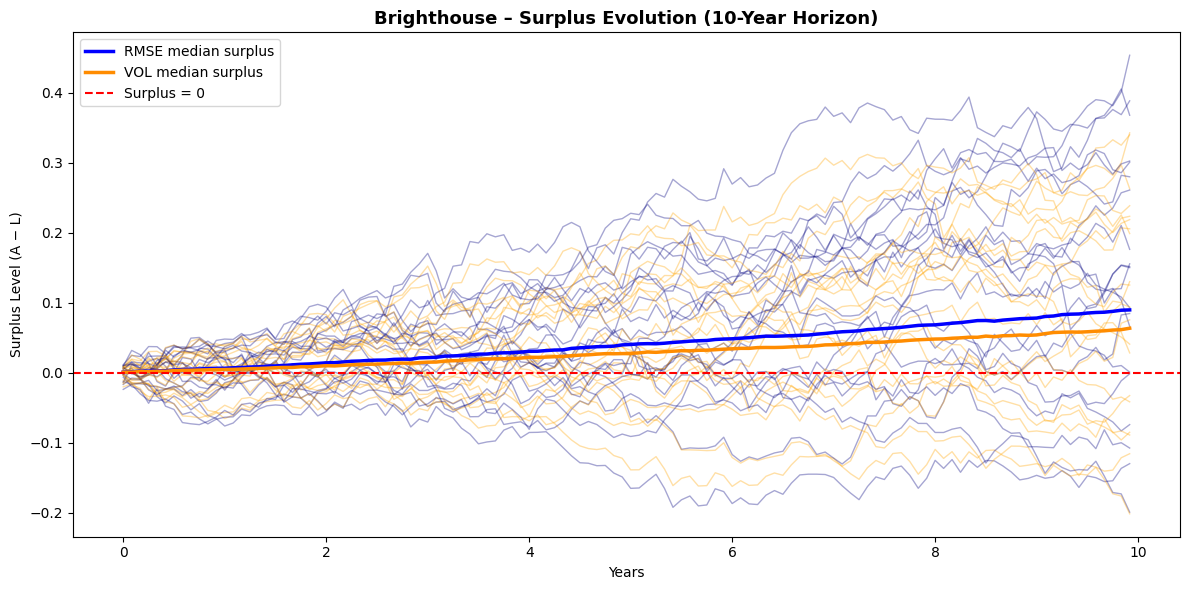

In [51]:
weights_rmse_Brighthouse = rmse_opt_Brighthouse["max_util_weights"]
weights_stdev_Brighthouse = stdev_opt_Brighthouse["max_util_weights"]
results = run_company_analysis("Brighthouse", weights_rmse_Brighthouse, weights_stdev_Brighthouse, RBC_charges=RBC_charges)


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.58%  |  VOL=0.41%  |  Δ=0.17%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=31.15%  |  VOL=35.15%  |  Δ=-4.00%
P(SurplusCAGR<Disc):RMSE=99.75% |  VOL=99.94% |  Δ=-0.19%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.80 |  VOL=0.67 |  Δ=0.13


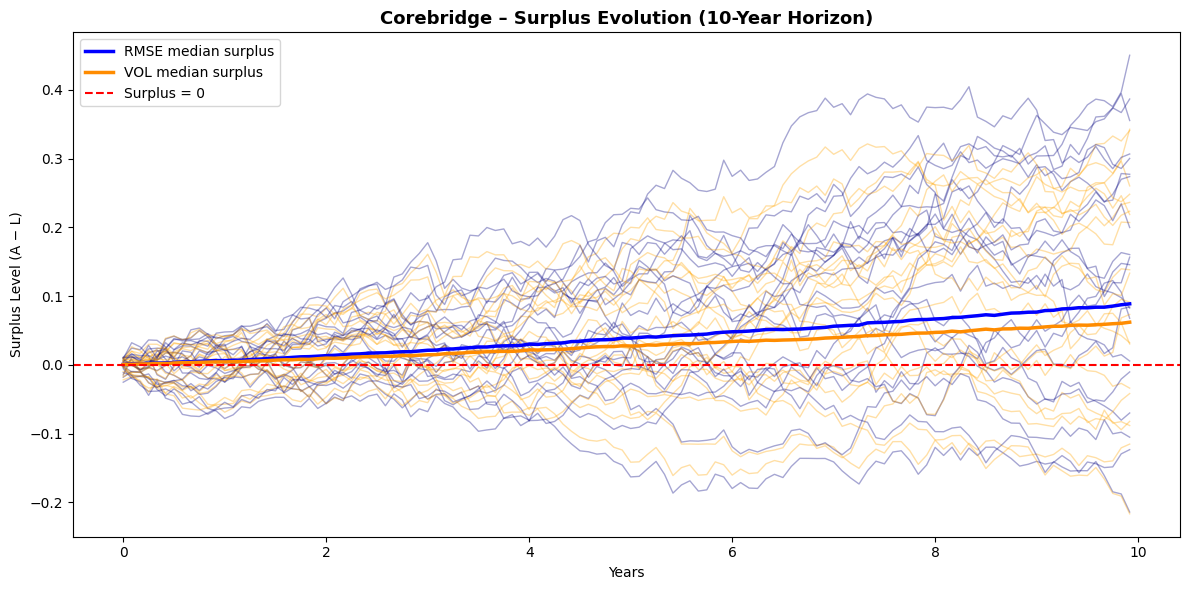

In [52]:
# === COREBRIDGE ANALYSIS ===
weights_rmse_Corebridge = rmse_opt_Corebridge["max_util_weights"]
weights_stdev_Corebridge = stdev_opt_Corebridge["max_util_weights"]
results_Corebridge = run_company_analysis("Corebridge", weights_rmse_Corebridge, weights_stdev_Corebridge, RBC_charges=RBC_charges)


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.60%  |  VOL=0.36%  |  Δ=0.24%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=31.88%  |  VOL=37.77%  |  Δ=-5.89%
P(SurplusCAGR<Disc):RMSE=99.56% |  VOL=99.82% |  Δ=-0.26%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.79 |  VOL=0.63 |  Δ=0.16


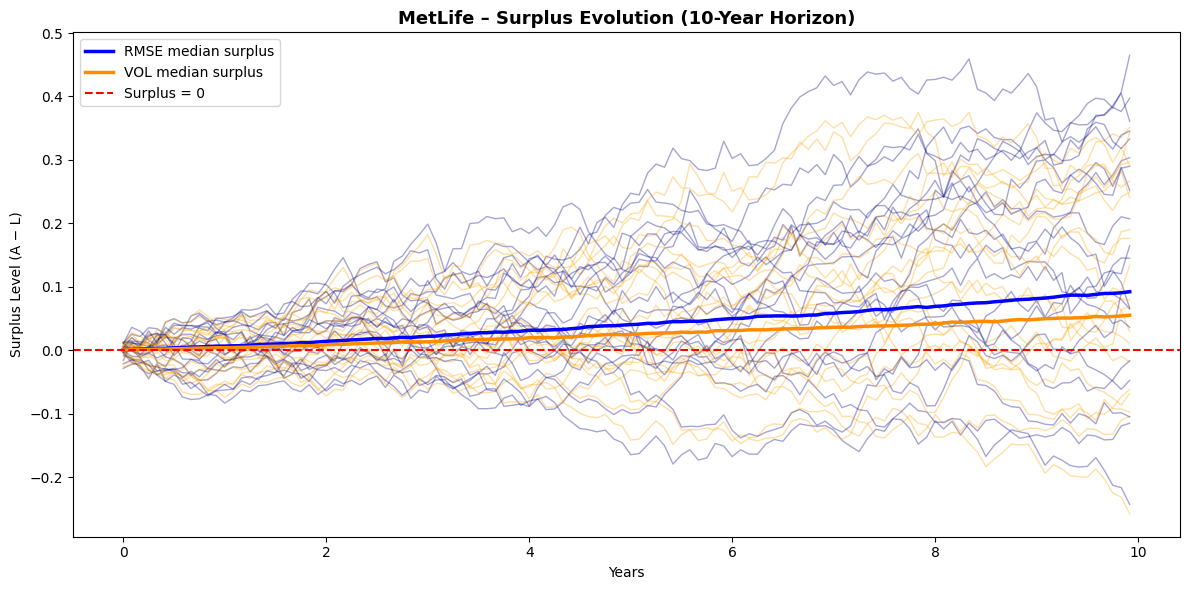

In [53]:
# === METLIFE ANALYSIS ===
weights_rmse_MetLife = rmse_opt_Metlife["max_util_weights"]
weights_stdev_MetLife = stdev_opt_Metlife["max_util_weights"]
results_MetLife = run_company_analysis("MetLife", weights_rmse_MetLife, weights_stdev_MetLife, RBC_charges=RBC_charges)


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.59%  |  VOL=0.35%  |  Δ=0.24%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=31.30%  |  VOL=37.50%  |  Δ=-6.20%
P(SurplusCAGR<Disc):RMSE=99.71% |  VOL=99.93% |  Δ=-0.22%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.81 |  VOL=0.59 |  Δ=0.22


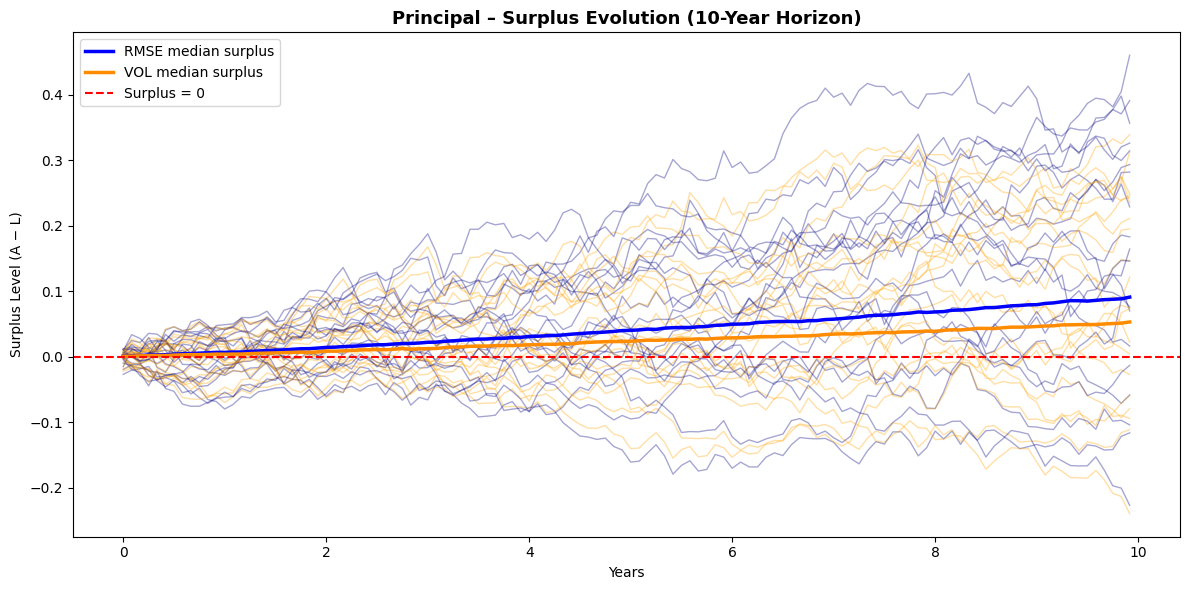

In [54]:
# === PRINCIPAL ANALYSIS ===
weights_rmse_Principal = rmse_opt_Principal["max_util_weights"]
weights_stdev_Principal = stdev_opt_Principal["max_util_weights"]
results_Principal = run_company_analysis("Principal", weights_rmse_Principal, weights_stdev_Principal, RBC_charges=RBC_charges)


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.60%  |  VOL=0.38%  |  Δ=0.22%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=31.26%  |  VOL=36.30%  |  Δ=-5.04%
P(SurplusCAGR<Disc):RMSE=99.71% |  VOL=99.93% |  Δ=-0.22%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.82 |  VOL=0.66 |  Δ=0.16


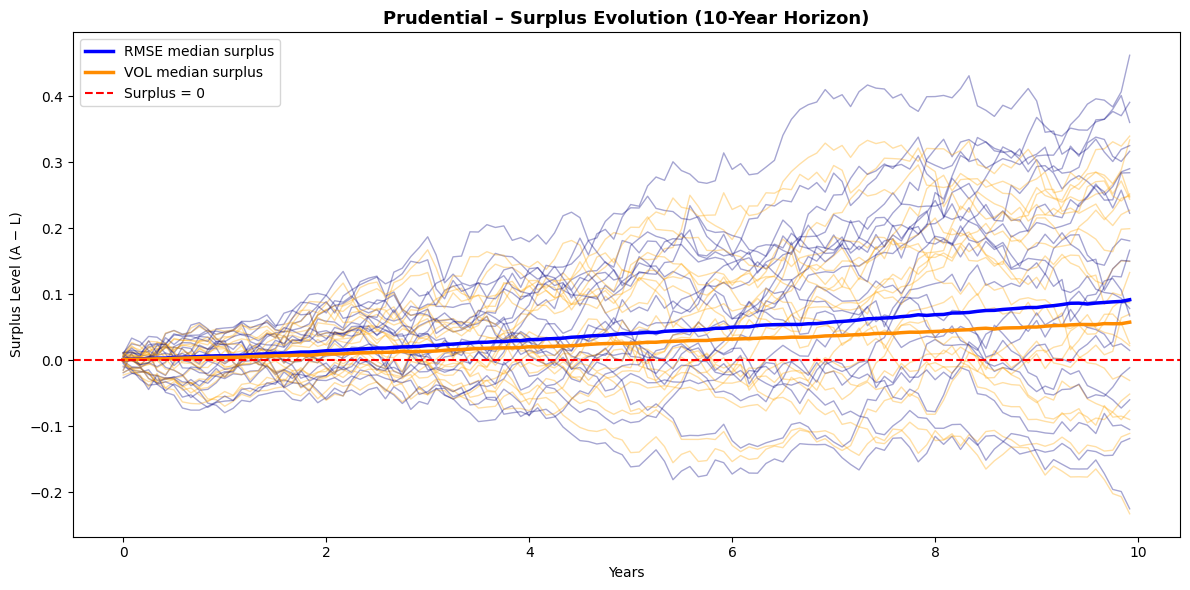

In [55]:
# === PRUDENTIAL ANALYSIS ===
weights_rmse_Prudential = rmse_opt_Prudential["max_util_weights"]
weights_stdev_Prudential = stdev_opt_Prudential["max_util_weights"]
results_Prudential = run_company_analysis("Prudential", weights_rmse_Prudential, weights_stdev_Prudential, RBC_charges=RBC_charges)


=== (Surplus performance) ===
Median Surplus CAGR: RMSE=0.60%  |  VOL=0.39%  |  Δ=0.21%
=== (Shortfall risk) ===
P(Surplus<0):       RMSE=30.95%  |  VOL=35.83%  |  Δ=-4.88%
P(SurplusCAGR<Disc):RMSE=99.71% |  VOL=99.93% |  Δ=-0.22%
=== (RBC efficiency) ===
Surplus/RBC:        RMSE=0.81 |  VOL=0.65 |  Δ=0.17


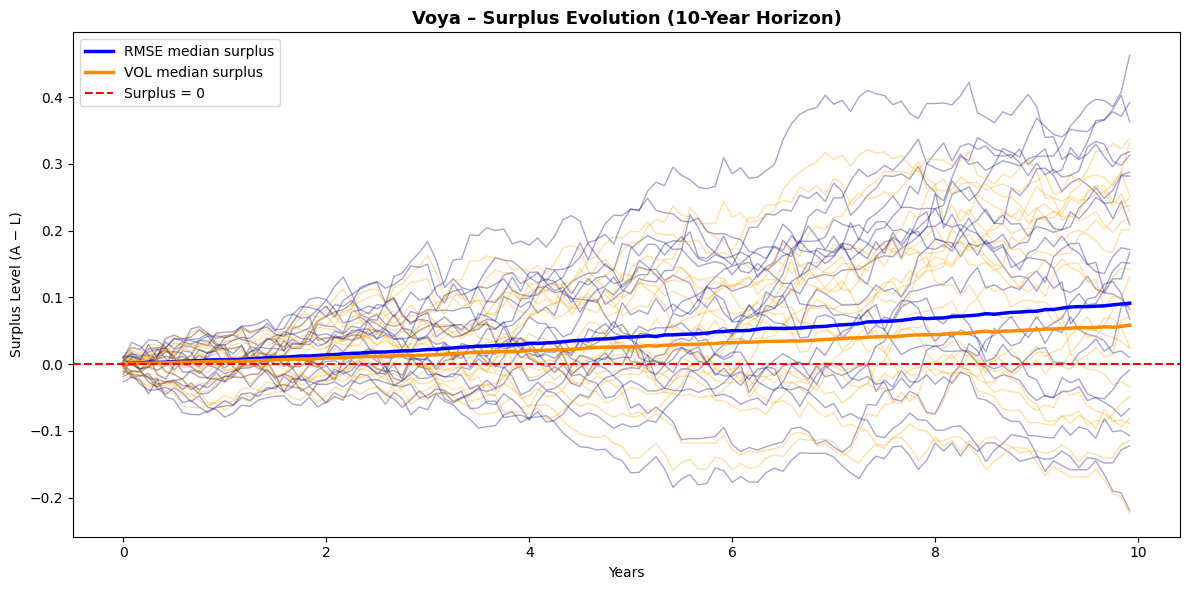

In [56]:
# === VOYA ANALYSIS ===
weights_rmse_Voya = rmse_opt_Voya["max_util_weights"]
weights_stdev_Voya = stdev_opt_Voya["max_util_weights"]
results_Voya = run_company_analysis("Voya", weights_rmse_Voya, weights_stdev_Voya, RBC_charges=RBC_charges)